In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import openpyxl
# Configure Matplotlib for better aesthetics
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (14, 6)
plt.rcParams['figure.dpi'] = 100


# # --- 1. DATA LOADING AND INITIAL INSPECTION ---

In [4]:


try:
    df = pd.read_excel(r'D:\Downloads_D\statathon\tstat_data1.xlsx')
    print("--- Initial Data Load Successful ---")
    print(f"Shape: {df.shape}")
    print(df.head())
except FileNotFoundError:
    print("ERROR: File 'tstat_data.xlsx' not found. Please update the file path.")
    # Create a dummy DataFrame if the file isn't found, so the rest of the code can be reviewed
    # This is a fallback and needs to be replaced with real data loading
    data = {
        'D1': [15, 15, 15], 'Month': ['May', 'May', 'May'], 'Time': ['4:56:35', '5:01:45', '5:06:53'], 'Year': [2025, 2025, 2025],
        '106Input packets/sec': [207, 185, 193], '106Input bits/sec': [397000, 376000, 389000],
        '106Output packets/sec': [87, 84, 88], '106Output bits/sec': [164000, 163000, 169000],
        '06Input packets/sec': [1, 0, 0], '06Input bits/sec': [2000, 0, 0],
        '06Output packets/sec': [1, 2, 0], '06Output bits/sec': [1000, 1000, 0]
    }
    df = pd.DataFrame(data)
    # Raising the error again to alert the user that they must fix the path



--- Initial Data Load Successful ---
Shape: (20510, 13)
   Date     DAY Month      Time  106Input packets/sec  106Input bits/sec  \
0     3  Monday   Mar  16:58:14                  1807            6300000   
1     3  Monday   Mar  17:03:20                  1643            6959000   
2     3  Monday   Mar  17:08:26                  1403            5459000   
3     3  Monday   Mar  17:13:32                  3106           11817000   
4     3  Monday   Mar  17:18:38                  2045            7405000   

   106Output packets/sec  106Output bits/sec  06Input packets/sec  \
0                    830             2766000                  111   
1                    766             3008000                  113   
2                    649             2165000                  106   
3                   1494             6339000                   69   
4                    999             4113000                   46   

   06Input bits/sec  06Output packets/sec  06Output bits/sec  Year  
0  

# --- 2. DATETIME INDEX CREATION (Handling the New 'Day' Column) ---

In [5]:


# The column names in the Excel file are now likely: 'Day', 'Date' (day number), 'Month', 'Time', 'Year'
# We will explicitly use 'Date', 'Month', 'Time', and 'Year' for the timestamp creation, 
# ignoring the descriptive 'Day' (e.g., Monday) column, as the DatetimeIndex will calculate the day of the week automatically.

df['datetime_str'] = df['Date'].astype(str) + ' ' + df['Month'].astype(str) + ' ' + df['Year'].astype(str) + ' ' + df['Time'].astype(str)

# Convert the combined string column to a proper pandas Datetime object
df['Timestamp'] = pd.to_datetime(df['datetime_str'], format='%d %b %Y %H:%M:%S', errors='coerce')

# Set the Timestamp column as the index, which is mandatory for time-series analysis
df = df.set_index('Timestamp')

# Remove the now-redundant original date/time columns (including the new 'Day' column if it exists)
cols_to_drop = ['Date', 'Month', 'Time', 'Year', 'datetime_str', 'DAY']
# Only drop columns that exist in the DataFrame (to handle the optional 'Day' column)
df = df.drop(columns=[col for col in cols_to_drop if col in df.columns], errors='ignore')

# Drop rows where the timestamp conversion or data collection might have failed
traffic_cols_original = [col for col in df.columns if 'packets' in col or 'bits' in col]
df = df.dropna(subset=traffic_cols_original)

## --- 3. COLUMN RENAMING AND CLEANUP --- 

In [6]:

# Define a mapping to simplify the very long column names
# VLAN ID (106 or 06) + Direction (Input/Output) + Metric (P=Packets, B=Bits)
new_columns = {
    '106Input packets/sec': 'VLAN106_Input_P',
    '106Input bits/sec': 'VLAN106_Input_B',
    '106Output packets/sec': 'VLAN106_Output_P',
    '106Output bits/sec': 'VLAN106_Output_B',
    '06Input packets/sec': 'VLAN06_Input_P',
    '06Input bits/sec': 'VLAN06_Input_B',
    '06Output packets/sec': 'VLAN06_Output_P',
    '06Output bits/sec': 'VLAN06_Output_B',
}

df = df.rename(columns=new_columns)

print("\n--- Processed Data Info ---")
print(df.info())
print("\nProcessed Head:")
print(df.head())


--- Processed Data Info ---
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 20510 entries, 2025-03-03 16:58:14 to 2025-05-15 23:59:09
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   VLAN106_Input_P   20510 non-null  int64
 1   VLAN106_Input_B   20510 non-null  int64
 2   VLAN106_Output_P  20510 non-null  int64
 3   VLAN106_Output_B  20510 non-null  int64
 4   VLAN06_Input_P    20510 non-null  int64
 5   VLAN06_Input_B    20510 non-null  int64
 6   VLAN06_Output_P   20510 non-null  int64
 7   VLAN06_Output_B   20510 non-null  int64
dtypes: int64(8)
memory usage: 1.4 MB
None

Processed Head:
                     VLAN106_Input_P  VLAN106_Input_B  VLAN106_Output_P  \
Timestamp                                                                 
2025-03-03 16:58:14             1807          6300000               830   
2025-03-03 17:03:20             1643          6959000               766   
2025-03-03 17:08:2

# # Ensure all new primary traffic columns are numeric (integer type)

In [7]:
final_metric_cols = list(new_columns.values())
for col in final_metric_cols:
    # Use to_numeric with 'coerce' to handle non-numeric values by turning them into NaN
    # Then fill NaNs with 0 (assuming corrupted or missing data is 0 traffic)
    df[col] = pd.to_numeric(df[col], errors='coerce').fillna(0).astype(np.int64)

# print("\n--- Processed Data Info ---")
# print(df.info())
# print("\nProcessed Head (with Datetime Index):")
# print(df.head())

# #  4. FEATURE ENGINEERING: TOTAL TRAFFIC & METRIC TRANSFORMATION 

In [8]:
# Calculate Total Traffic (Input + Output Bits) for easier comparison
df['VLAN106_Total_B'] = df['VLAN106_Input_B'] + df['VLAN106_Output_B']
df['VLAN06_Total_B'] = df['VLAN06_Input_B'] + df['VLAN06_Output_B']

# Create the Packets-to-Bits Ratio (measure of packet size/traffic type)
# We use a small epsilon (1e-6) to avoid division by zero
epsilon = 1e-6
df['VLAN106_Pkt_Ratio'] = df['VLAN106_Input_P'] / (df['VLAN106_Input_B'] + epsilon)
df['VLAN06_Pkt_Ratio'] = df['VLAN06_Input_P'] / (df['VLAN06_Input_B'] + epsilon)

# Convert bits/sec to Megabits/sec (Mb/s) for human-readable plotting
MBIT = 1000000
df['VLAN106_Total_Mb'] = df['VLAN106_Total_B'] / MBIT
df['VLAN06_Total_Mb'] = df['VLAN06_Total_B'] / MBIT



# # --- 5. EXPLORATORY DATA ANALYSIS (EDA) - FINDING LONG-TERM TRENDS 

# Total network Traffic

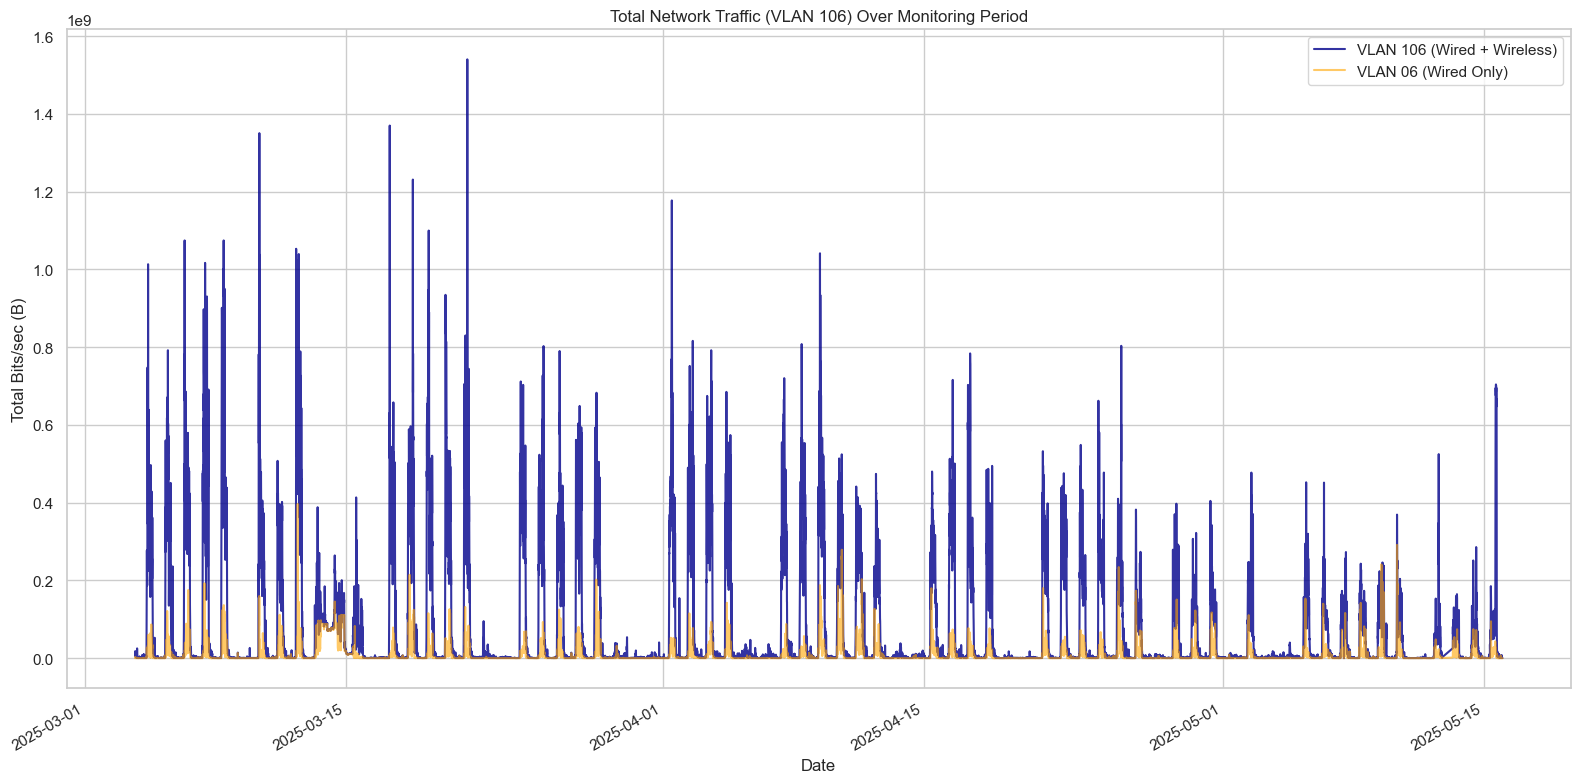

In [9]:
plt.figure(figsize=(16, 8))
# Plotting the total traffic for the main VLAN (106)
df['VLAN106_Total_B'].plot(
    title='Total Network Traffic (VLAN 106) Over Monitoring Period',
    label='VLAN 106 (Wired + Wireless)',
    color='darkblue',
    alpha=0.8
)
# Plotting the wired-only VLAN (06) for comparison
df['VLAN06_Total_B'].plot(
    title='Total Network Traffic (VLAN 106) Over Monitoring Period',
    label='VLAN 06 (Wired Only)',
    color='orange',
    alpha=0.6
)
plt.ylabel('Total Bits/sec (B)')
plt.xlabel('Date')
plt.legend()
plt.tight_layout()
plt.show()

# Daily Averaged Total Traffic (March to July)

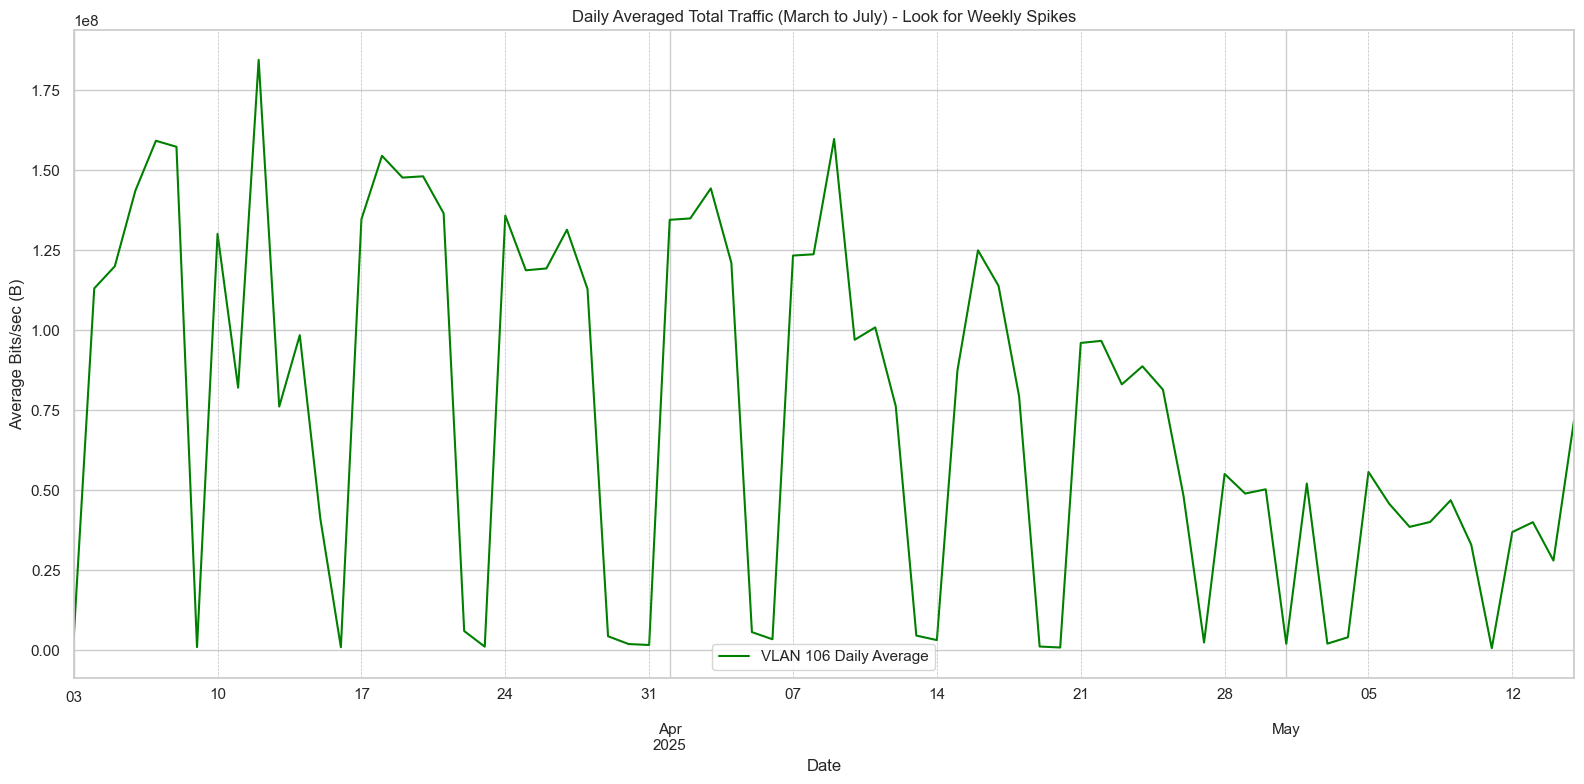

In [10]:

# Resample to Daily Mean to smooth out noise and highlight weekly patterns
df_daily = df[['VLAN106_Total_B', 'VLAN06_Total_B']].resample('D').mean()

plt.figure(figsize=(16, 8))
df_daily['VLAN106_Total_B'].plot(
    label='VLAN 106 Daily Average',
    color='green'
)
# Add vertical lines for the start of each week to visualize the weekly cycle
for week_start in df_daily.index[df_daily.index.dayofweek == 0]: # Monday is 0
    plt.axvline(x=week_start, color='gray', linestyle='--', linewidth=0.5, alpha=0.5)

plt.title('Daily Averaged Total Traffic (March to July) - Look for Weekly Spikes')
plt.ylabel('Average Bits/sec (B)')
plt.xlabel('Date')
plt.legend()
plt.tight_layout()
plt.show()



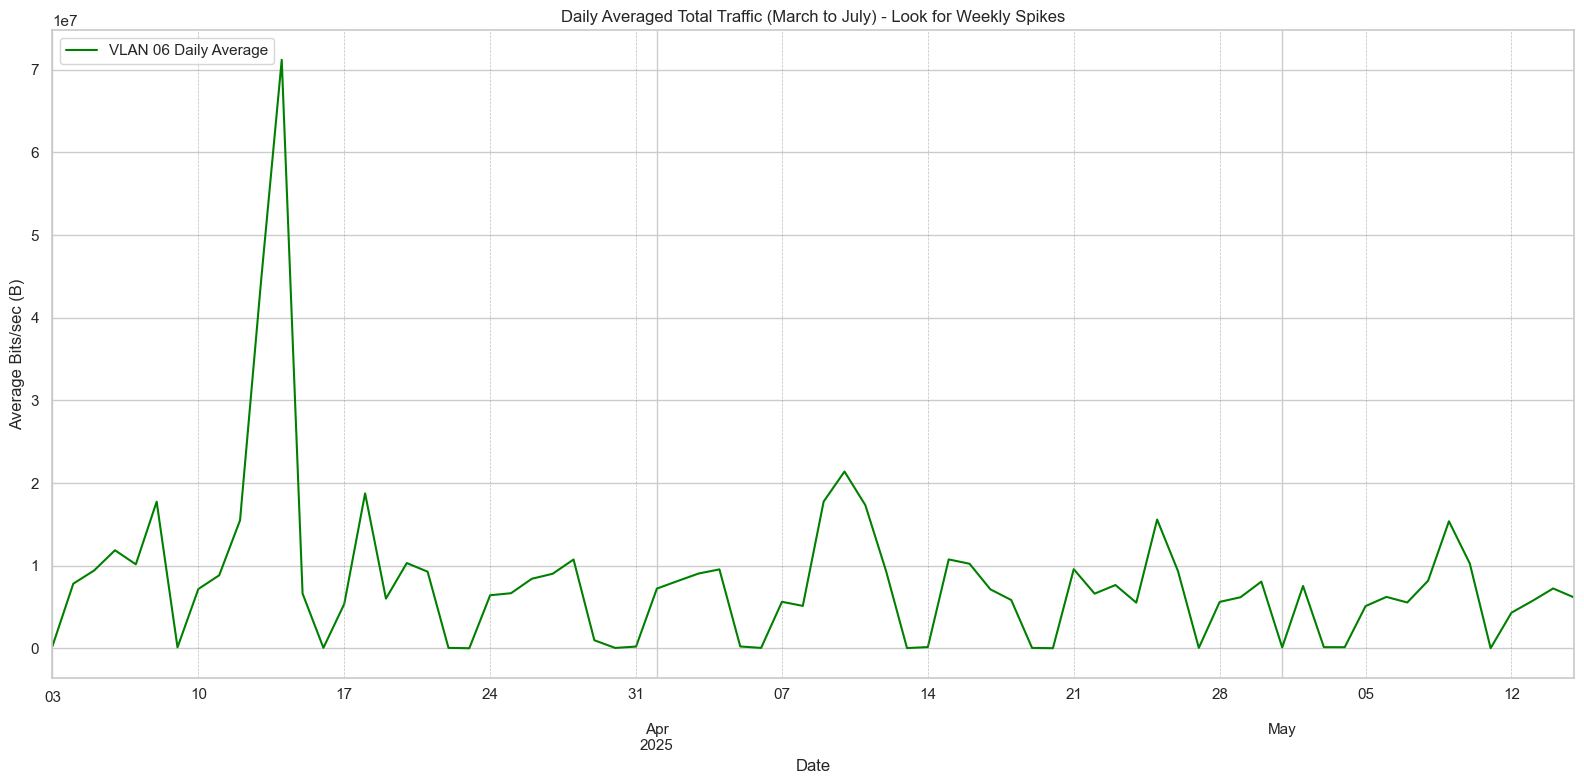

In [11]:
plt.figure(figsize=(16, 8))
df_daily['VLAN06_Total_B'].plot(
    label='VLAN 06 Daily Average',
    color='green'
)
# Add vertical lines for the start of each week to visualize the weekly cycle
for week_start in df_daily.index[df_daily.index.dayofweek == 0]: # Monday is 0
    plt.axvline(x=week_start, color='gray', linestyle='--', linewidth=0.5, alpha=0.5)

plt.title('Daily Averaged Total Traffic (March to July) - Look for Weekly Spikes')
plt.ylabel('Average Bits/sec (B)')
plt.xlabel('Date')
plt.legend()
plt.tight_layout()
plt.show()

#  ISOLATE A TYPICAL WEEK (Confirming Peak Hours) ---

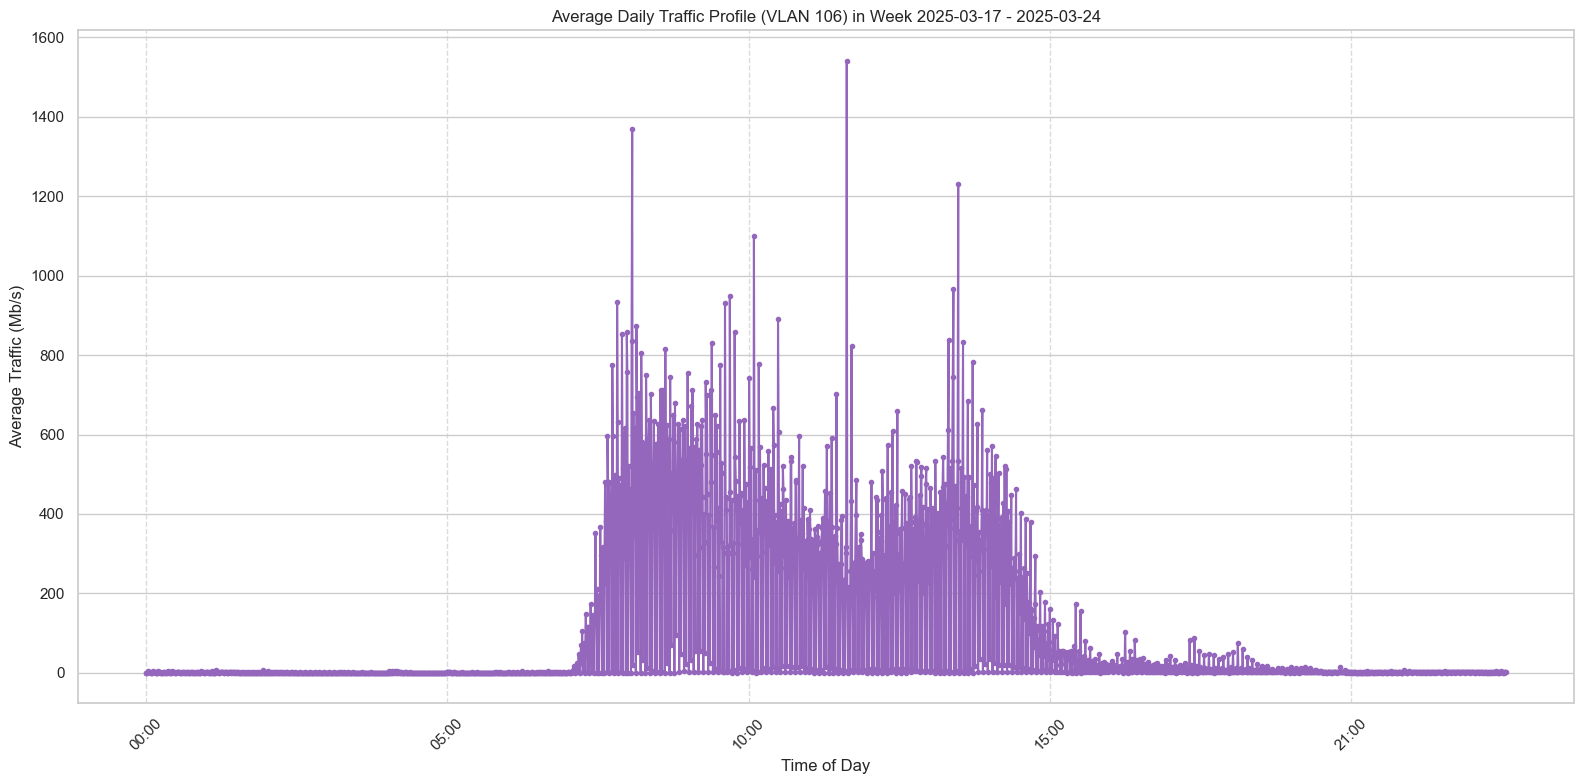

In [12]:
# Select an arbitrary, representative week (e.g., starting March 17th)
# You may want to choose a different week after looking at the full trend plot.
start_date = '2025-03-17' 
end_date = '2025-03-24' 
df_week = df.loc[start_date:end_date]

plt.figure(figsize=(16, 8))

# FIX: Select the calculated column 'VLAN106_Total_Mb' from the weekly slice before grouping.
# This ensures the column exists in the aggregated result (df_daily_profile).
df_daily_profile = df_week['VLAN106_Total_Mb'].groupby(df_week.index.time).mean()
# Create a proxy index for plotting (e.g., 0-23 hours)
hourly_index = [f"{t.hour:02d}:00" for t in df_daily_profile.index]
df_daily_profile.index = hourly_index
    
# Plot the average daily profile
# Since df_daily_profile is now a Pandas Series, we plot it directly.
df_daily_profile.plot(
    label='VLAN 106 Average Daily Profile',
    color='#9467bd',
    marker='o',
    markersize=3
)

plt.xticks(rotation=45)
plt.title(f'Average Daily Traffic Profile (VLAN 106) in Week {start_date} - {end_date}')
plt.ylabel('Average Traffic (Mb/s)')
plt.xlabel('Time of Day')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

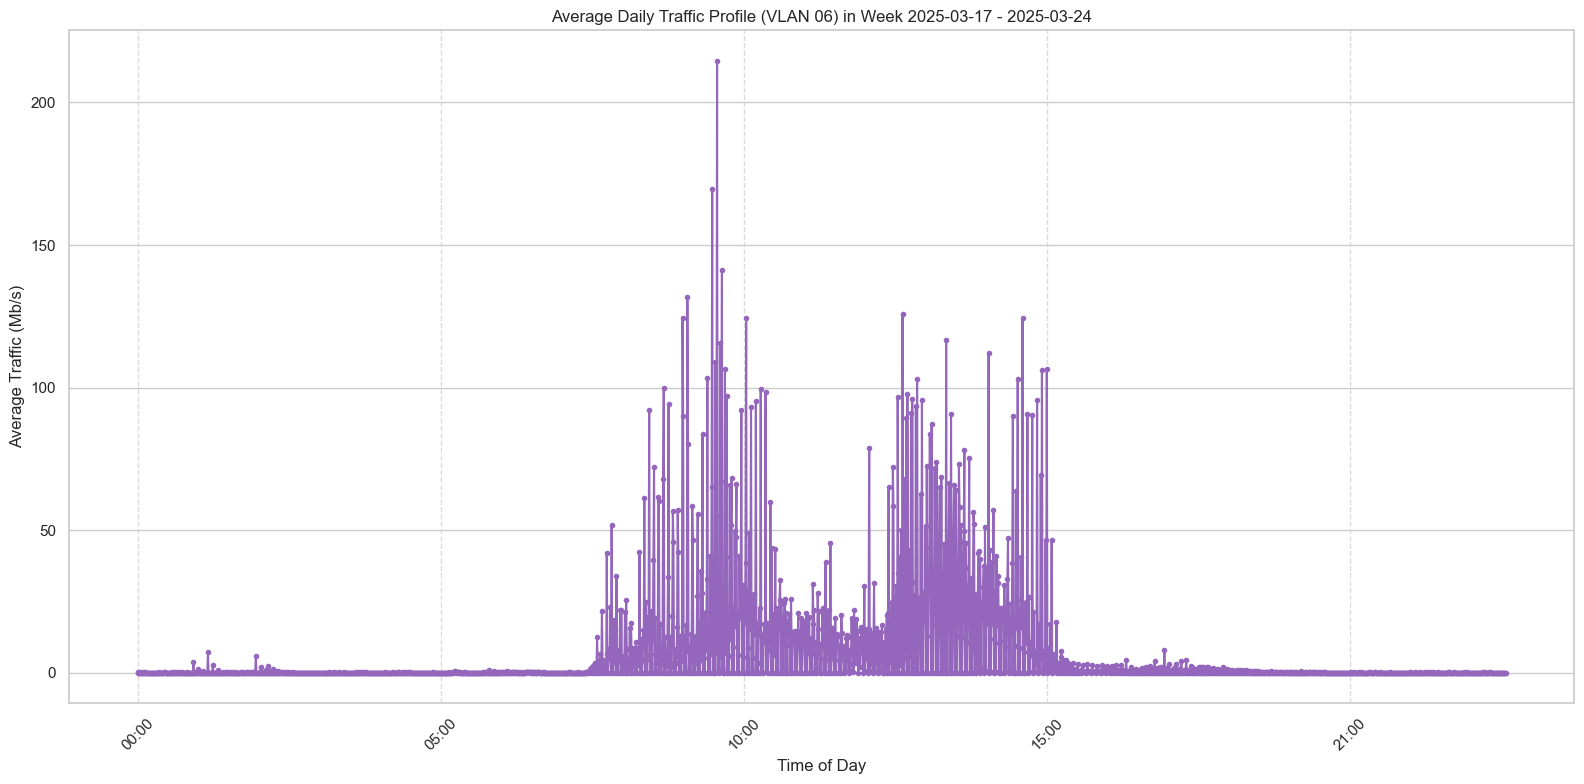

In [13]:
start_date = '2025-03-17' 
end_date = '2025-03-24' 
df_week = df.loc[start_date:end_date]

plt.figure(figsize=(16, 8))

# FIX: Select the calculated column 'VLAN106_Total_Mb' from the weekly slice before grouping.
# This ensures the column exists in the aggregated result (df_daily_profile).
df_daily_profile = df_week['VLAN06_Total_Mb'].groupby(df_week.index.time).mean()
# Create a proxy index for plotting (e.g., 0-23 hours)
hourly_index = [f"{t.hour:02d}:00" for t in df_daily_profile.index]
df_daily_profile.index = hourly_index
    
# Plot the average daily profile
# Since df_daily_profile is now a Pandas Series, we plot it directly.
df_daily_profile.plot(
    label='VLAN 06 Average Daily Profile',
    color='#9467bd',
    marker='o',
    markersize=3
)

plt.xticks(rotation=45)
plt.title(f'Average Daily Traffic Profile (VLAN 06) in Week {start_date} - {end_date}')
plt.ylabel('Average Traffic (Mb/s)')
plt.xlabel('Time of Day')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

#  TRAFFIC TYPE ANALYSIS (Packet Ratio Trend) 

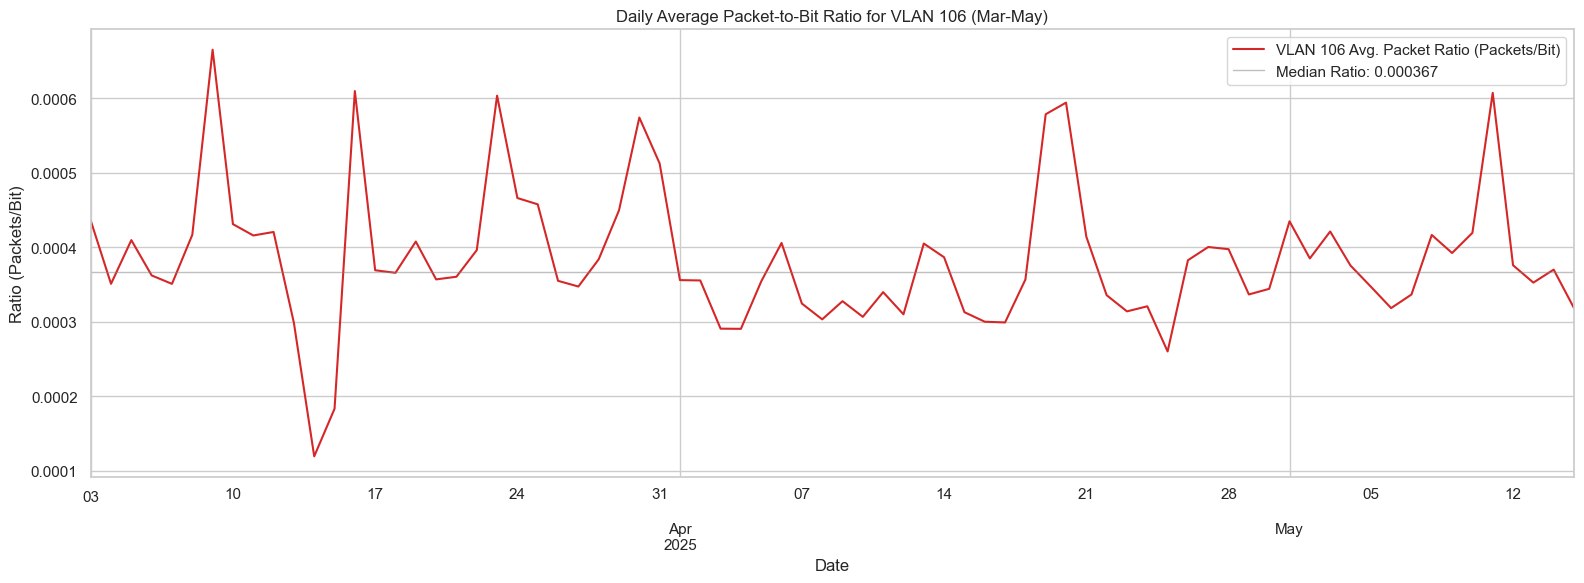

In [14]:
# Resample the Packet Ratio to a daily mean to visualize long-term shifts in traffic type
df_ratio_daily = df[['VLAN106_Pkt_Ratio', 'VLAN06_Pkt_Ratio']].resample('D').mean()

plt.figure(figsize=(16, 6))

df_ratio_daily['VLAN106_Pkt_Ratio'].plot(
    label='VLAN 106 Avg. Packet Ratio (Packets/Bit)',
    color='#d62728',
    linewidth=1.5
)

# Plot a horizontal line at the median ratio for context
median_ratio = df_ratio_daily['VLAN106_Pkt_Ratio'].median()
plt.axhline(median_ratio, color='gray', linestyle='-', linewidth=1, alpha=0.5, label=f'Median Ratio: {median_ratio:.6f}')

plt.title('Daily Average Packet-to-Bit Ratio for VLAN 106 (Mar-May)')
plt.ylabel('Ratio (Packets/Bit)')
plt.xlabel('Date')
plt.legend()
plt.tight_layout()
plt.show()

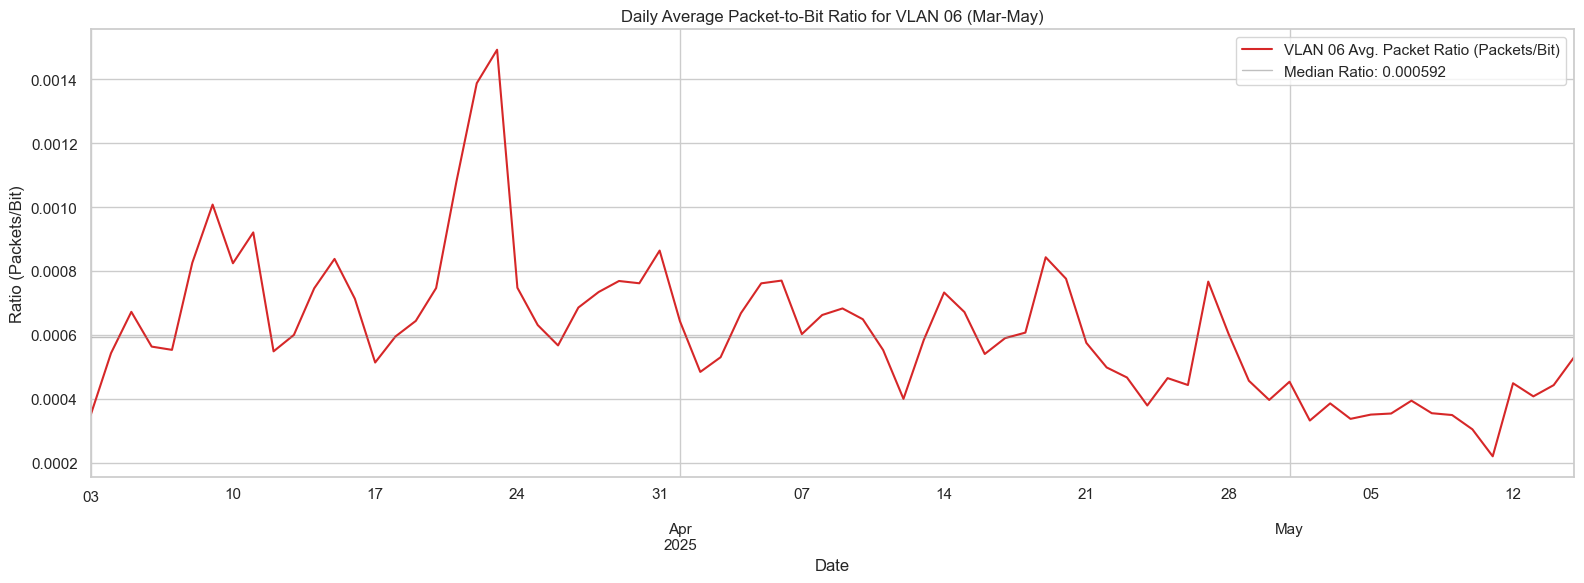

In [15]:
plt.figure(figsize=(16, 6))

df_ratio_daily['VLAN06_Pkt_Ratio'].plot(
    label='VLAN 06 Avg. Packet Ratio (Packets/Bit)',
    color='#d62728',
    linewidth=1.5
)

# Plot a horizontal line at the median ratio for context
median_ratio = df_ratio_daily['VLAN06_Pkt_Ratio'].median()
plt.axhline(median_ratio, color='gray', linestyle='-', linewidth=1, alpha=0.5, label=f'Median Ratio: {median_ratio:.6f}')

plt.title('Daily Average Packet-to-Bit Ratio for VLAN 06 (Mar-May)')
plt.ylabel('Ratio (Packets/Bit)')
plt.xlabel('Date')
plt.legend()
plt.tight_layout()
plt.show()

#  WEEKLY DEMAND ANALYSIS (Finding the Most Demanding Day)

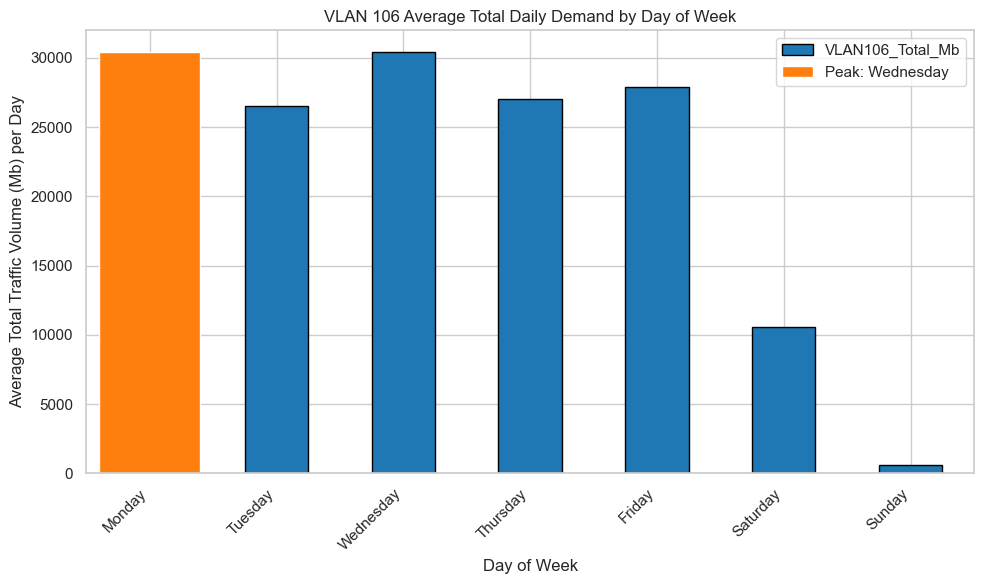


--- Daily Demand Analysis Complete ---
The most demanding day on average is: Wednesday (Average Traffic: 30,463 Mb)
This result should be integrated with the Academic Calendar external data for a full context.


In [16]:
# Calculate the average total traffic for VLAN 106 for each day of the week
# We must resample to daily totals *first* to avoid averaging 5-minute samples over the month,
# then group those daily totals by the day of the week.

# 1. Calculate Daily Total Traffic (Sum all 5-minute intervals for each day)
df_daily_totals = df.resample('D')['VLAN106_Total_Mb'].sum()

# 2. Group the daily totals by the day of the week (0=Monday, 6=Sunday) and calculate the average
# FIX APPLIED: Grouping is now done on the index of the new df_daily_totals Series.
df_day_avg = df_daily_totals.groupby(df_daily_totals.index.dayofweek).mean()

# 3. Define the day names for plotting
day_names = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
df_day_avg.index = day_names

plt.figure(figsize=(10, 6))
df_day_avg.plot(
    kind='bar',
    color='#1f77b4',
    edgecolor='black'
)

# Annotate the peak day
peak_day = df_day_avg.idxmax()
peak_traffic = df_day_avg.max()
plt.bar(peak_day, peak_traffic, color='#ff7f0e', label=f'Peak: {peak_day}')


plt.title('VLAN 106 Average Total Daily Demand by Day of Week')
plt.ylabel('Average Total Traffic Volume (Mb) per Day')
plt.xlabel('Day of Week')
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.tight_layout()
plt.show()

print("\n--- Daily Demand Analysis Complete ---")
print(f"The most demanding day on average is: {peak_day} (Average Traffic: {peak_traffic:,.0f} Mb)")
print("This result should be integrated with the Academic Calendar external data for a full context.")


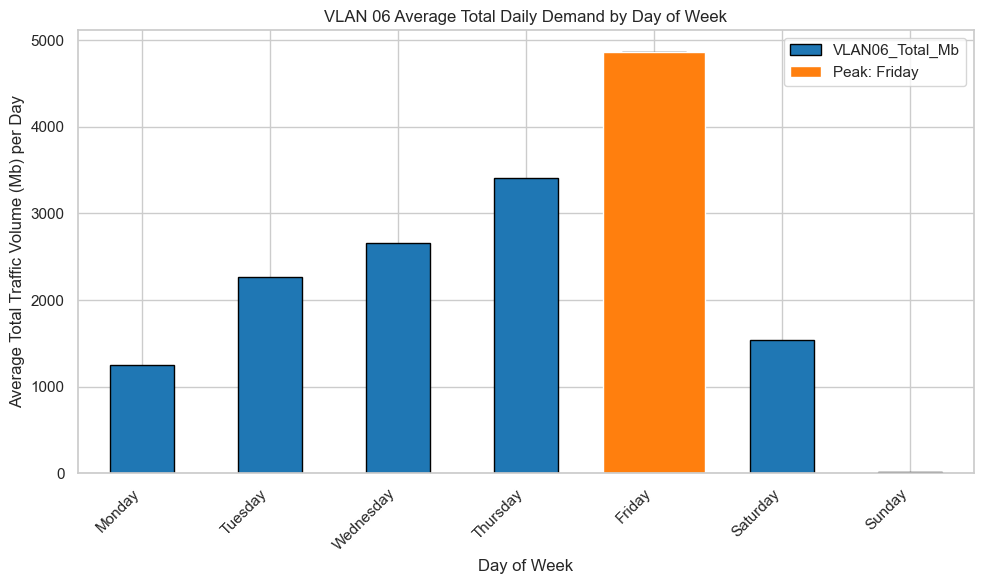


--- Daily Demand Analysis Complete ---
The most demanding day on average is: Friday (Average Traffic: 4,869 Mb)
This result should be integrated with the Academic Calendar external data for a full context.


In [17]:
# Calculate the average total traffic for VLAN 06 for each day of the week
# We must resample to daily totals *first* to avoid averaging 5-minute samples over the month,
# then group those daily totals by the day of the week.

# 1. Calculate Daily Total Traffic (Sum all 5-minute intervals for each day)
df_daily_totals = df.resample('D')['VLAN06_Total_Mb'].sum()

# 2. Group the daily totals by the day of the week (0=Monday, 6=Sunday) and calculate the average
df_day_avg = df_daily_totals.groupby(df_daily_totals.index.dayofweek).mean()

# 3. Define the day names for plotting
day_names = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
df_day_avg.index = day_names

plt.figure(figsize=(10, 6))
# First, plot all bars (using the default color)
df_day_avg.plot(
    kind='bar',
    color='#1f77b4',
    edgecolor='black'
)

# Annotate and highlight the peak day
peak_day = df_day_avg.idxmax()
peak_traffic = df_day_avg.max()

# --- FIX APPLIED ---
# Get the numerical index (position) of the peak day in the series
peak_position = df_day_avg.index.get_loc(peak_day)

# Then, plot ONLY the peak bar using the numerical position
plt.bar(peak_position, peak_traffic, color='#ff7f0e', label=f'Peak: {peak_day}')


plt.title('VLAN 06 Average Total Daily Demand by Day of Week')
plt.ylabel('Average Total Traffic Volume (Mb) per Day')
plt.xlabel('Day of Week')
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.tight_layout()
plt.show()

print("\n--- Daily Demand Analysis Complete ---")
print(f"The most demanding day on average is: {peak_day} (Average Traffic: {peak_traffic:,.0f} Mb)")
print("This result should be integrated with the Academic Calendar external data for a full context.")


# Daily average plots for all weeks 


--- Generating Individual Weekly Profiles (Vertical Plots) ---


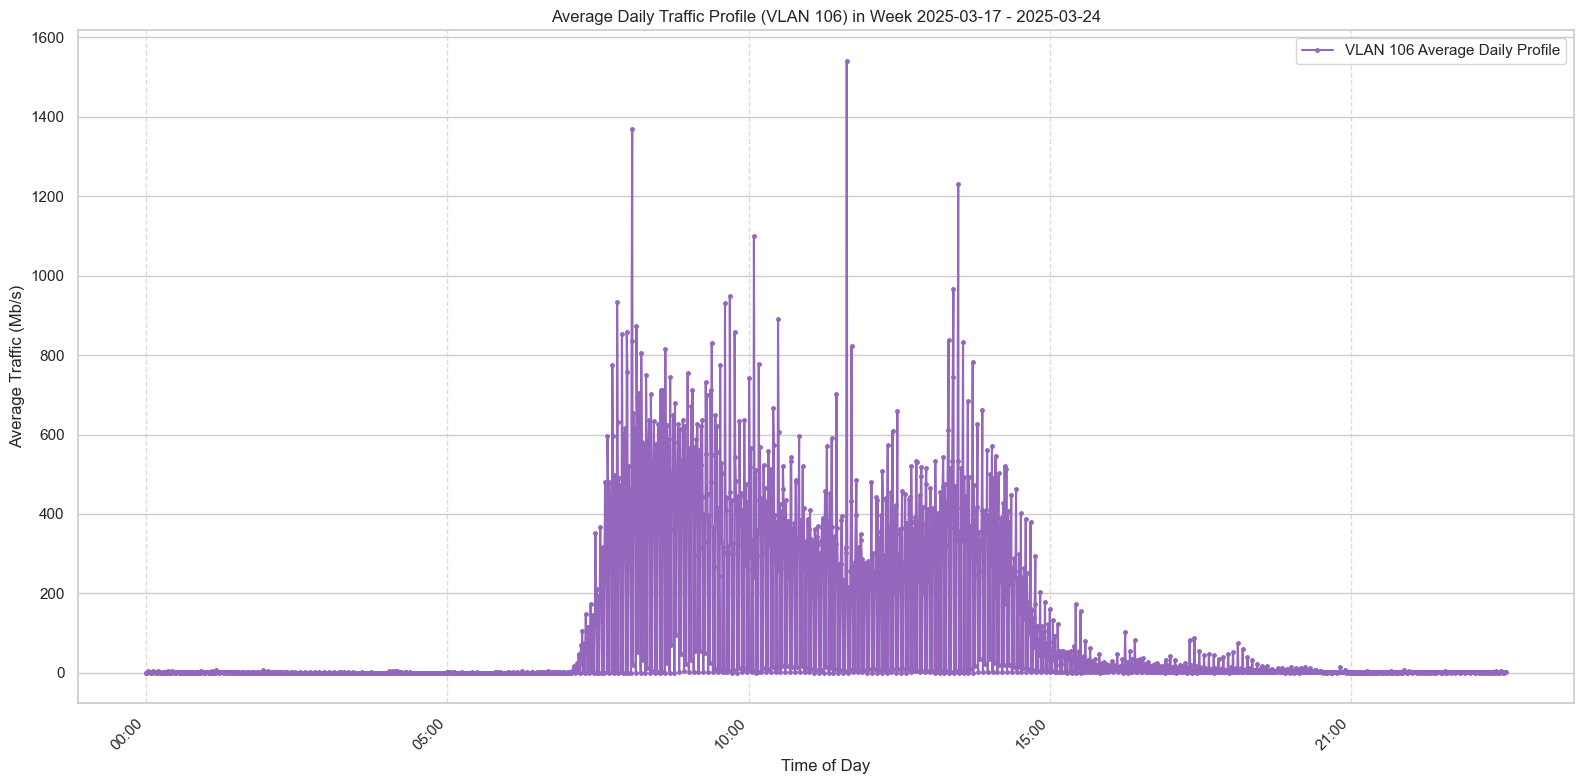

--- Profile for Week 2025-03-17 Complete ---


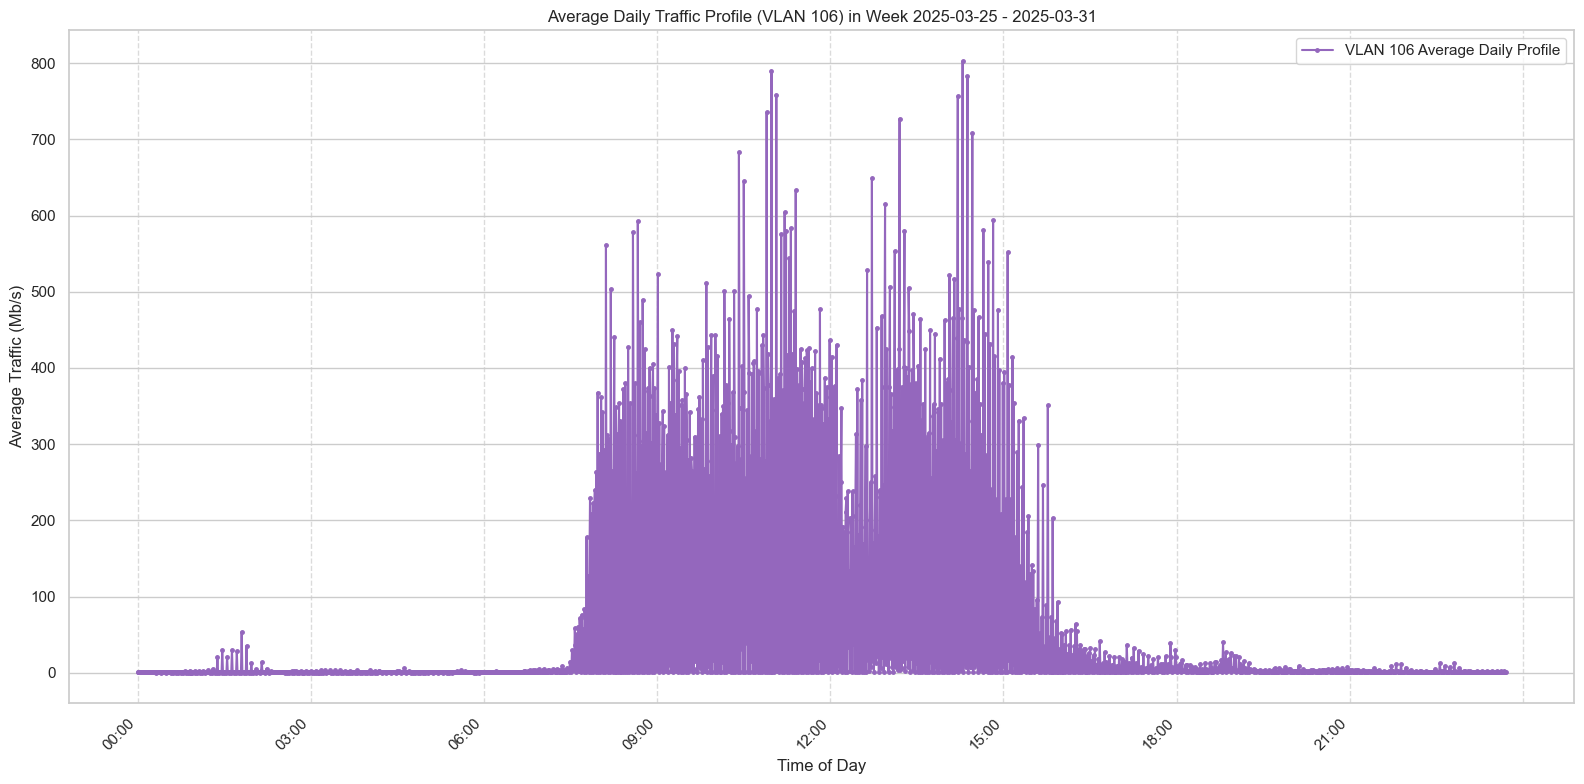

--- Profile for Week 2025-03-25 Complete ---


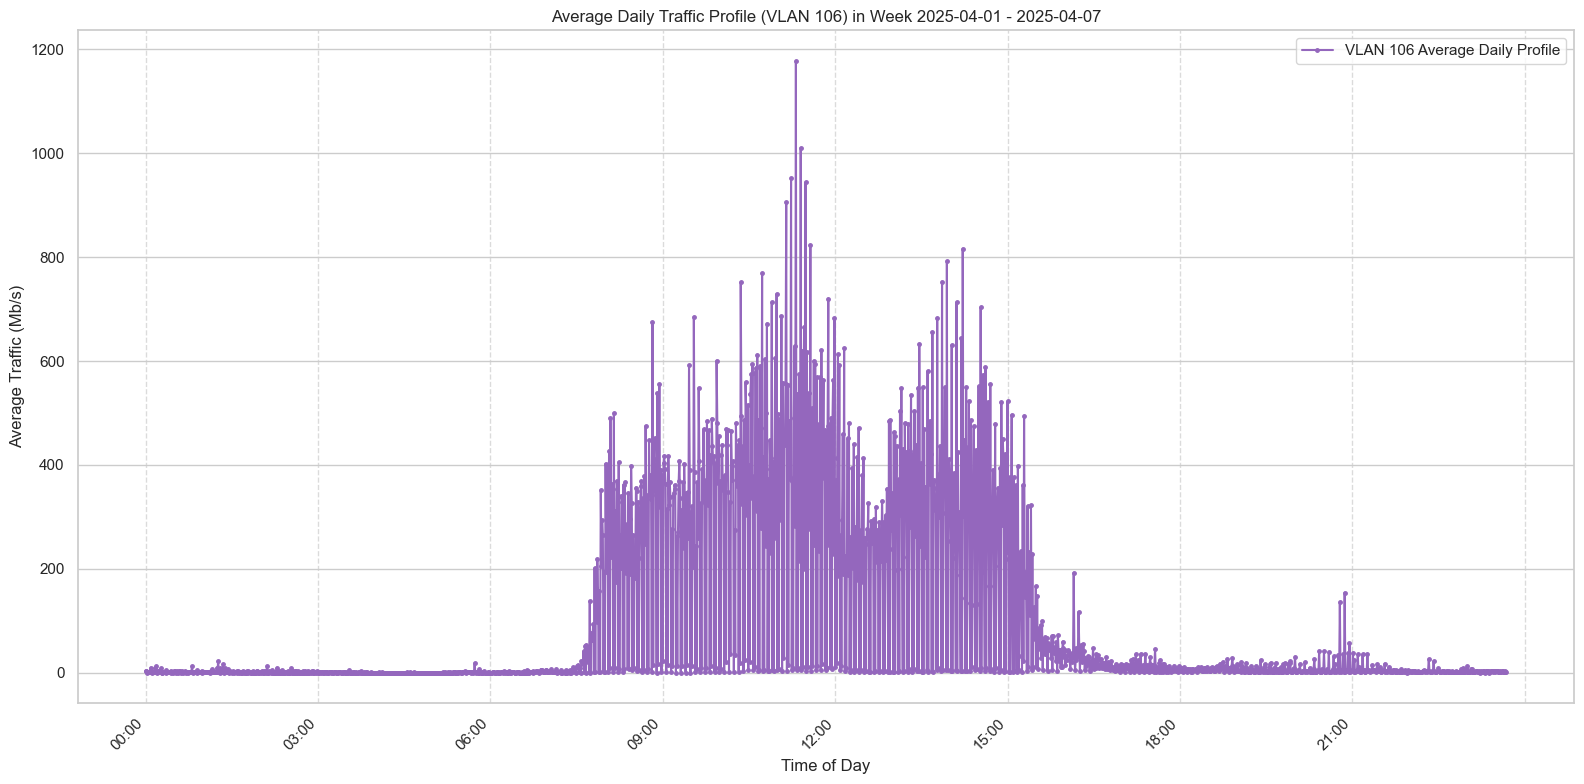

--- Profile for Week 2025-04-01 Complete ---

--- Individual Weekly Profile Analysis Complete ---


In [18]:
def plot_average_daily_profile(start_date, end_date, df):
    """Calculates and plots the average daily traffic profile for a given date range."""
    
    # 1. Slice the data for the current week
    # Ensure end_date doesn't exceed available data
    df_week = df.loc[start_date:min(end_date, df.index.max().strftime('%Y-%m-%d'))]['VLAN106_Total_Mb']
    
    # Check if data exists for the period
    if df_week.empty:
        print(f"Warning: No data found for the period {start_date} to {end_date}.")
        return

    # 2. Calculate the average traffic profile over the period (group by time-of-day)
    df_daily_profile = df_week.groupby(df_week.index.time).mean()
    
    # 3. Create a proxy index for plotting (e.g., 00:00, 05:00, etc.)
    hourly_index = [f"{t.hour:02d}:00" for t in df_daily_profile.index]
    df_daily_profile.index = hourly_index
    
    plt.figure(figsize=(16, 8)) # Use the large, standard size (16, 8)
    
    # 4. Plot the data (as a Pandas Series, plotting directly)
    df_daily_profile.plot(
        label='VLAN 106 Average Daily Profile',
        color='#9467bd',
        marker='.',
        markersize=5,
        linewidth=1.5
    )
    
    # 5. Customize the plot
    plt.xticks(rotation=45, ha='right')
    plt.title(f'Average Daily Traffic Profile (VLAN 106) in Week {start_date} - {end_date}')
    plt.ylabel('Average Traffic (Mb/s)')
    plt.xlabel('Time of Day')
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    print(f"--- Profile for Week {start_date} Complete ---")


# --- Define the Weeks to Plot ---
# This list can be customized to any weeks you want to inspect individually.
# Example includes: Normal, Mid-Shift, and Final Week
weeks_to_plot = [
    ('2025-03-17', '2025-03-24', 'Normal Semester Week'),
    ('2025-03-25', '2025-03-31', 'Normal Semester Week'),
    ('2025-04-01', '2025-04-07', 'Normal Semester Week')
#     ('2025-04-14', '2025-04-21', 'Academic Shift Week (Mid-Terms/Study)'),
#     ('2025-05-12', '2025-05-19', 'End of Semester Week'),
]

print("\n--- Generating Individual Weekly Profiles (Vertical Plots) ---")
for start_date, end_date, label in weeks_to_plot:
    plot_average_daily_profile(start_date, end_date, df)

print("\n--- Individual Weekly Profile Analysis Complete ---")


--- Generating Individual Weekly Profiles (Vertical Plots) ---


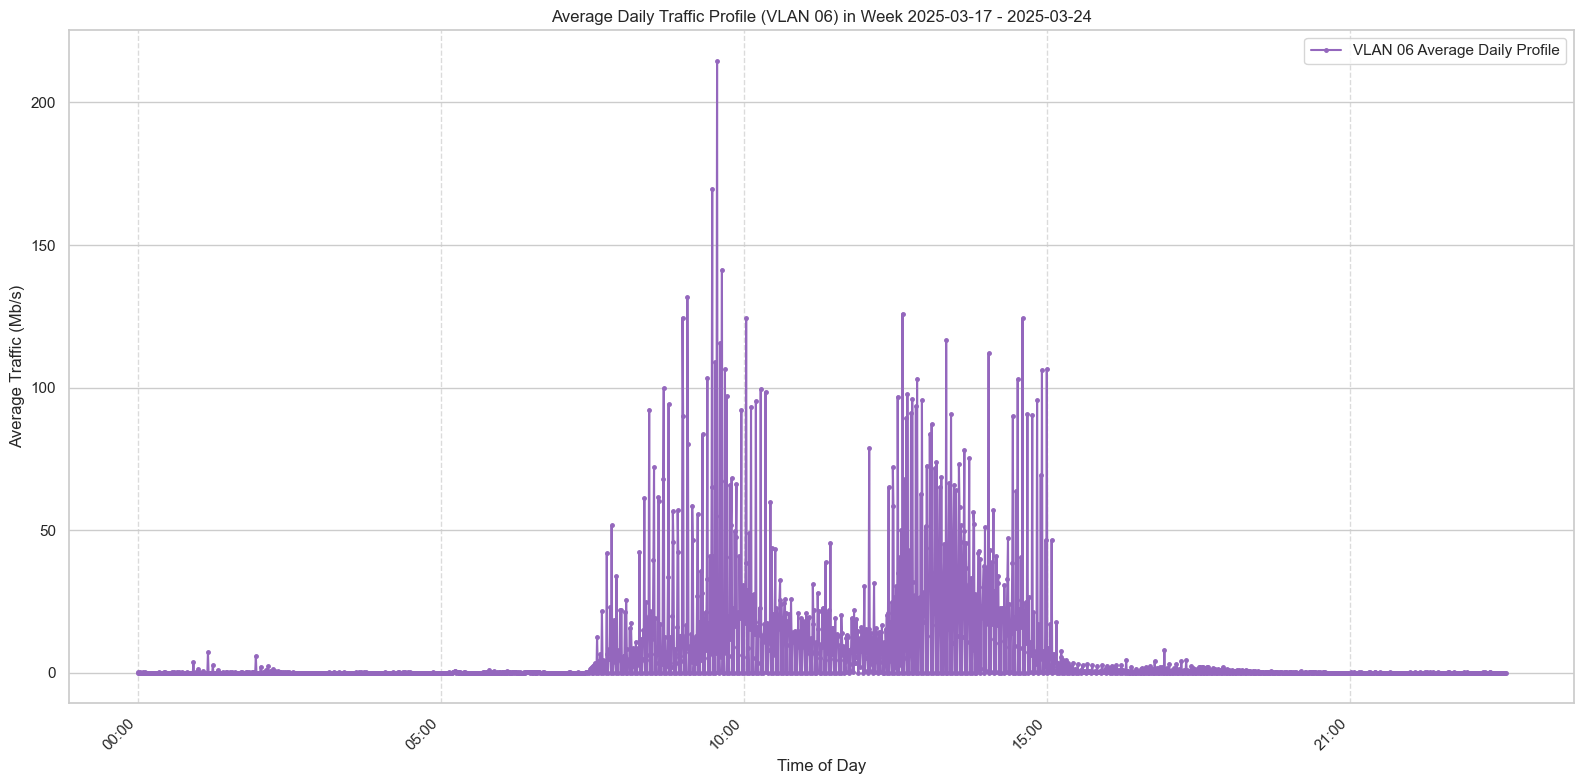

--- Profile for Week 2025-03-17 Complete ---


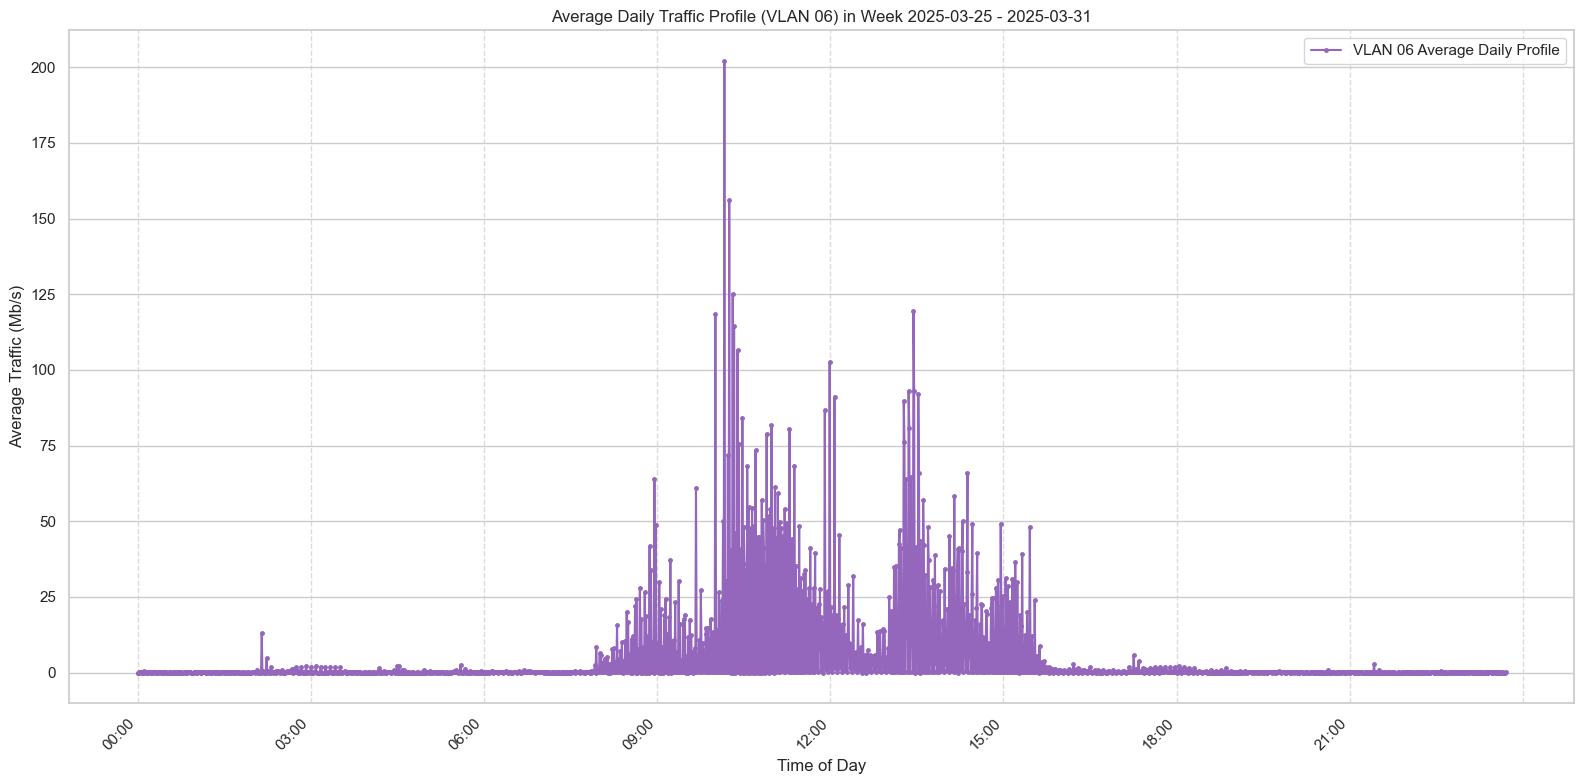

--- Profile for Week 2025-03-25 Complete ---


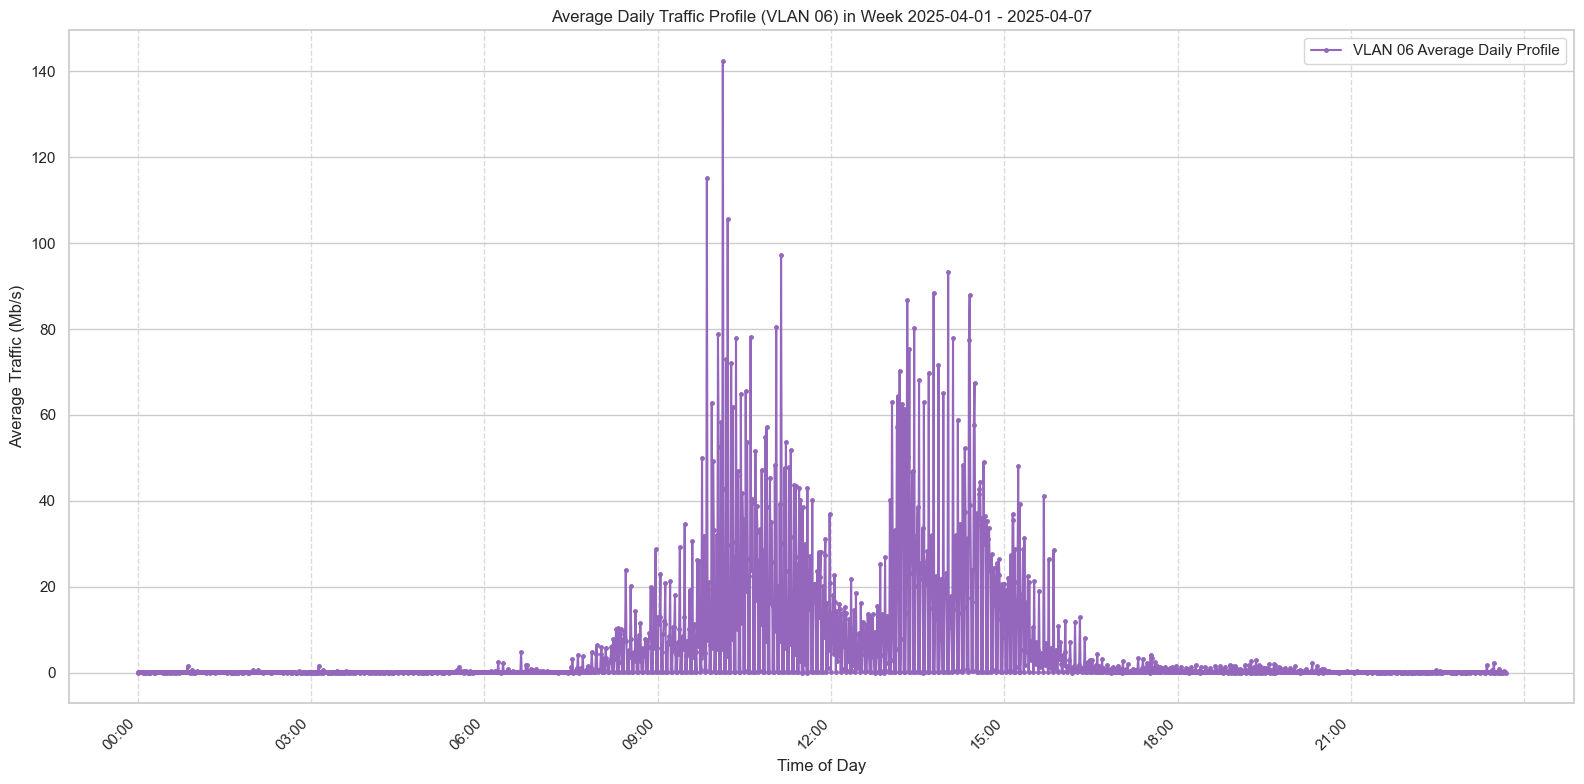

--- Profile for Week 2025-04-01 Complete ---

--- Individual Weekly Profile Analysis Complete ---


In [19]:
def plot_average_daily_profile(start_date, end_date, df):
    """Calculates and plots the average daily traffic profile for a given date range."""
    
    # 1. Slice the data for the current week
    # Ensure end_date doesn't exceed available data
    df_week = df.loc[start_date:min(end_date, df.index.max().strftime('%Y-%m-%d'))]['VLAN06_Total_Mb']
    
    # Check if data exists for the period
    if df_week.empty:
        print(f"Warning: No data found for the period {start_date} to {end_date}.")
        return

    # 2. Calculate the average traffic profile over the period (group by time-of-day)
    df_daily_profile = df_week.groupby(df_week.index.time).mean()
    
    # 3. Create a proxy index for plotting (e.g., 00:00, 05:00, etc.)
    hourly_index = [f"{t.hour:02d}:00" for t in df_daily_profile.index]
    df_daily_profile.index = hourly_index
    
    plt.figure(figsize=(16, 8)) # Use the large, standard size (16, 8)
    
    # 4. Plot the data (as a Pandas Series, plotting directly)
    df_daily_profile.plot(
        label='VLAN 06 Average Daily Profile',
        color='#9467bd',
        marker='.',
        markersize=5,
        linewidth=1.5
    )
    
    # 5. Customize the plot
    plt.xticks(rotation=45, ha='right')
    plt.title(f'Average Daily Traffic Profile (VLAN 06) in Week {start_date} - {end_date}')
    plt.ylabel('Average Traffic (Mb/s)')
    plt.xlabel('Time of Day')
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    print(f"--- Profile for Week {start_date} Complete ---")


# --- Define the Weeks to Plot ---
# This list can be customized to any weeks you want to inspect individually.
# Example includes: Normal, Mid-Shift, and Final Week
weeks_to_plot = [
    ('2025-03-17', '2025-03-24', 'Normal Semester Week'),
    ('2025-03-25', '2025-03-31', 'Normal Semester Week'),
    ('2025-04-01', '2025-04-07', 'Normal Semester Week'),
]

print("\n--- Generating Individual Weekly Profiles (Vertical Plots) ---")
for start_date, end_date, label in weeks_to_plot:
    plot_average_daily_profile(start_date, end_date, df)

print("\n--- Individual Weekly Profile Analysis Complete ---")

# # --- 9. NEXT PHASE: DECOMPOSITION AND MODEL PREPARATION ---


--- PHASE 2: EDA DEEP DIVE COMPLETE ---
We have visualized long-term trends, weekly seasonality, and traffic composition.
The next critical step is formal **Time-Series Decomposition (STL)**.
This will mathematically isolate the Trend, the repeating Seasonal component, and the non-modeled Residual (anomaly detection target).

Mode of Time Interval: 0 days 00:05:06


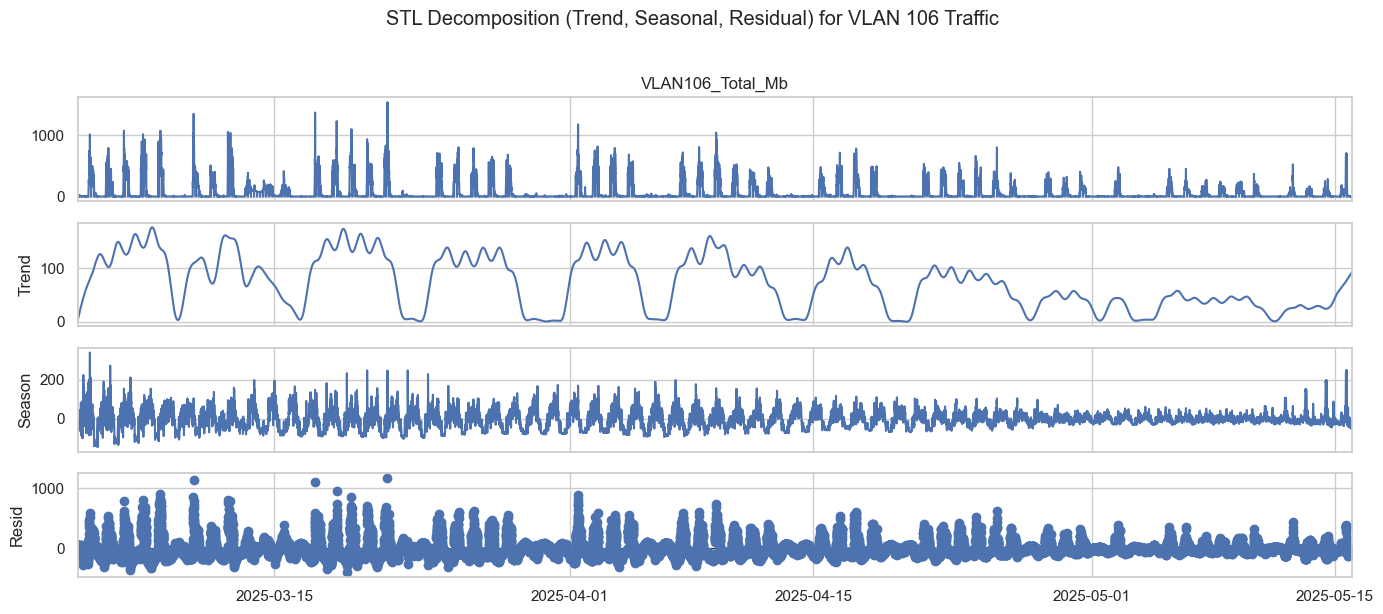


STL Decomposition Complete. The Residual plot is your primary Anomaly Signal.

All EDA steps are now complete, and we have isolated the anomaly signal!


In [20]:
from statsmodels.tsa.seasonal import STL


print("\n--- PHASE 2: EDA DEEP DIVE COMPLETE ---")
print("We have visualized long-term trends, weekly seasonality, and traffic composition.")
print("The next critical step is formal **Time-Series Decomposition (STL)**.")
print("This will mathematically isolate the Trend, the repeating Seasonal component, and the non-modeled Residual (anomaly detection target).")

# --- 10. PREPARING FOR DECOMPOSITION (Optional but Recommended) ---

# For STL decomposition, the index must be uniform. The sampling interval is ~5 minutes.
# We will check if the data needs resampling to a perfect 5-minute frequency.
# First, let's identify the dominant frequency (mode) of the interval differences
interval_mode = df.index.to_series().diff().mode()[0]

print(f"\nMode of Time Interval: {interval_mode}")

# Resample to the fixed interval for precise STL decomposition
# Note: Use 'mean' or 'sum' depending on whether you want average rate or total volume
df_resampled = df['VLAN106_Total_Mb'].resample('5min').mean()
df_resampled = df_resampled.fillna(0) # Fill missing 5-min intervals with 0, assuming no traffic

# Execute STL Decomposition on the resampled data (VLAN106 Total Mb)
try:
    # Period 2016 for 5-minute data (48 samples/day * 7 days = 336)
    # Since the data covers ~2.5 months, setting a period based on the weekly cycle is robust.
    # period=336 corresponds to a weekly seasonality with 5-minute sampling
    stl = STL(df_resampled, period=336, seasonal=13).fit() # seasonal=13 means seasonal component takes up 13 data points around it (odd number recommended)

    # Plot the decomposition
    stl.plot()
    plt.suptitle('STL Decomposition (Trend, Seasonal, Residual) for VLAN 106 Traffic', y=1.02)
    plt.tight_layout()
    plt.show()

    # Save the residual component as the first iteration of your anomaly signal
    df['Anomaly_Residual'] = stl.resid
    print("\nSTL Decomposition Complete. The Residual plot is your primary Anomaly Signal.")

except Exception as e:
    print(f"\nERROR during STL Decomposition: {e}")
    print("STL decomposition requires a long, regular time series. If your data has many missing intervals or the time delta is inconsistent, resampling helps, but may still fail.")

print("\nAll EDA steps are now complete, and we have isolated the anomaly signal!")


# # --- 10. ANOMALY CLASSIFICATION MODEL (Is it DDoS or Download?) ---


--- 12. ANOMALY CLASSIFICATION RESULTS (Top 5 Events) ---
We use the Packet Ratio and Input/Output metrics to distinguish traffic types.

Top 5 Classified Anomaly Events:
                     VLAN106_Pkt_Ratio  VLAN106_Total_Mb  \
Timestamp                                                  
2025-03-18 14:50:00           0.000219           560.944   
2025-03-04 08:57:07           0.000197           689.760   
2025-03-04 09:02:13           0.000182           747.976   
2025-03-04 09:07:19           0.000191           646.935   
2025-03-04 09:37:55           0.000145           896.644   

                                Anomaly_Type  
Timestamp                                     
2025-03-18 14:50:00  Massive Download/Update  
2025-03-04 08:57:07  Massive Download/Update  
2025-03-04 09:02:13  Massive Download/Update  
2025-03-04 09:07:19  Massive Download/Update  
2025-03-04 09:37:55  Massive Download/Update  

Total Anomalies Detected by Isolation Forest: 206


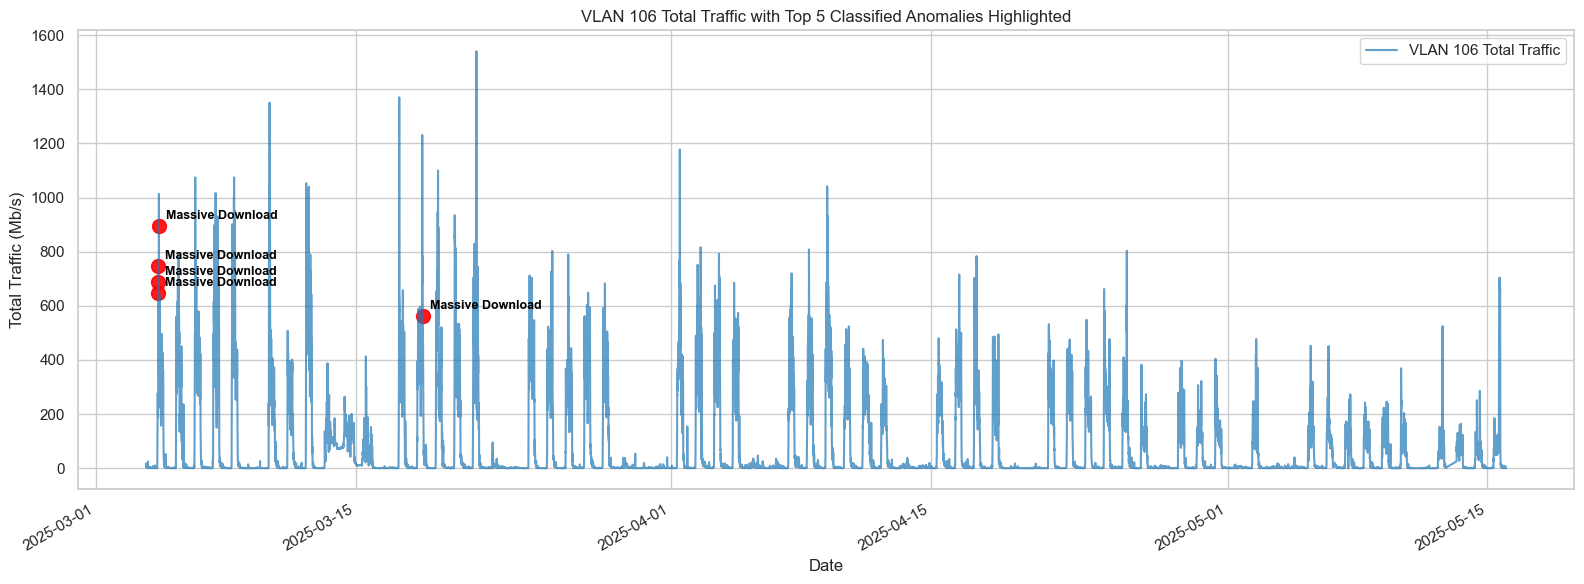


--- INFERENCE MODELING COMPLETE ---


In [21]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.ensemble import IsolationForest 
from scipy.stats import zscore # Used for simple anomaly detection threshold
# 12.1 ISOLATE ANOMALIES AND FEATURES
# Merge the residual data (from STL) back into the main DataFrame
df_temp = df[['VLAN106_Pkt_Ratio', 'VLAN106_Input_P', 'VLAN106_Output_P', 'VLAN106_Total_Mb']].copy()

# Add the Anomaly Residuals. This assumes Section 10 ran successfully and created df['Anomaly_Residual']
# We only care about positive residuals (traffic is higher than expected)
df_temp['Anomaly_Score'] = df['Anomaly_Residual'].abs()

# Set a threshold for identifying "major" anomalies (e.g., 3 standard deviations above the mean residual)
# This will be used for visualization, the Isolation Forest handles its own threshold internally.
residual_mean = df_temp['Anomaly_Score'].mean()
residual_std = df_temp['Anomaly_Score'].std()
ANOMALY_ZSCORE_THRESHOLD = residual_mean + (3 * residual_std)

# Select only the features crucial for traffic type classification
anomaly_features = df_temp[['VLAN106_Pkt_Ratio', 'VLAN106_Input_P', 'VLAN106_Output_P', 'VLAN106_Total_Mb']].dropna()

# 12.2 UNSUPERVISED ANOMALY DETECTION (Isolation Forest)
# Isolation Forest is great for identifying outliers without training labels
# Contamination is the expected proportion of outliers (setting to 1% based on visual inspection of residual plot)
iforest = IsolationForest(contamination=0.01, random_state=42)
df_temp['Isolation_Anomaly'] = iforest.fit_predict(anomaly_features)

# Convert I-Forest output: 1 (Normal), -1 (Anomaly) -> 0 (Normal), 1 (Anomaly)
df_temp['Isolation_Anomaly'] = df_temp['Isolation_Anomaly'].apply(lambda x: 1 if x == -1 else 0)


# 12.3 CLASSIFYING THE ANOMALY TYPE (DDoS vs. Download)
# We will define a simple rule-based classifier based on network principles:
# 1. DDoS/Scan: High Packet Ratio (small packets) AND High Input Flow (attack traffic).
# 2. Huge Download: Low Packet Ratio (large packets) AND High Input Flow (file transfer).

def classify_anomaly_type(row):
    if row['Isolation_Anomaly'] == 1:
        # Check if the event is dominated by small packets (High Pkt_Ratio)
        if row['VLAN106_Pkt_Ratio'] > median_ratio:
            # Check for a high input/output imbalance (DDoS often floods input, downloads have balanced output Acks)
            if row['VLAN106_Input_P'] > 2 * row['VLAN106_Output_P']:
                return "DDoS/Scan Activity"
            else:
                return "Unusual Chatty App"
        # Check if the event is dominated by large packets (Low Pkt_Ratio)
        elif row['VLAN106_Pkt_Ratio'] < median_ratio:
            return "Massive Download/Update"
    return "Normal"

df_temp['Anomaly_Type'] = df_temp.apply(classify_anomaly_type, axis=1)

# 12.4 FINAL OUTPUT AND VISUALIZATION
major_anomalies = df_temp[df_temp['Isolation_Anomaly'] == 1].sort_values(by='Anomaly_Score', ascending=False)
top_5_anomalies = major_anomalies.head(5)

print("\n--- 12. ANOMALY CLASSIFICATION RESULTS (Top 5 Events) ---")
print("We use the Packet Ratio and Input/Output metrics to distinguish traffic types.")
print("\nTop 5 Classified Anomaly Events:")
print(top_5_anomalies[['VLAN106_Pkt_Ratio', 'VLAN106_Total_Mb', 'Anomaly_Type']])
print(f"\nTotal Anomalies Detected by Isolation Forest: {len(major_anomalies)}")

# Visualize the Classified Anomalies over the original time series
plt.figure(figsize=(16, 6))
df_temp['VLAN106_Total_Mb'].plot(label='VLAN 106 Total Traffic (Mb/s)', color='#1f77b4', alpha=0.7)

# Highlight the top 5 anomalies on the plot
for index, row in top_5_anomalies.iterrows():
    plt.scatter(
        index, 
        row['VLAN106_Total_Mb'], 
        color='red', 
        s=100, 
        label=row['Anomaly_Type'] if index == top_5_anomalies.index[0] else None,
        alpha=0.9
    )
    plt.annotate(
        row['Anomaly_Type'].split('/')[0], # Use only the main label for annotation
        (index, row['VLAN106_Total_Mb']),
        xytext=(5, 5),
        textcoords='offset points',
        fontsize=9,
        color='black',
        weight='bold'
    )

plt.title('VLAN 106 Total Traffic with Top 5 Classified Anomalies Highlighted')
plt.ylabel('Total Traffic (Mb/s)')
plt.xlabel('Date')
plt.legend(['VLAN 106 Total Traffic'])
plt.tight_layout()
plt.show()

print("\n--- INFERENCE MODELING COMPLETE ---")

# # --- 11. BUILDING THE PREDICTIVE (CONGESTION FORECASTING) MODEL (LSTM) ---

# # 11.1 PREPARE DATA FOR LSTM (Sequence-to-Sequence Modeling)

In [3]:
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import joblib

# We will use the raw VLAN106 metrics (B/P) plus the Pkt_Ratio feature as multivariate inputs (X).
# The target (Y) will be the VLAN106_Total_Mb.

# Define input features and target
features = [
    'VLAN106_Input_B', 'VLAN106_Output_B', 
    'VLAN106_Input_P', 'VLAN106_Output_P',
    'VLAN106_Pkt_Ratio'
]
target = 'VLAN106_Total_Mb'
LOOKBACK = 48 # Use the past 4 hours of 5-minute data (48 samples) to predict the future.

# Create the final, clean dataset for the model (resampled to a fixed interval)
df_model = df[features + [target]].resample('5min').mean().fillna(0)

# Scale the data (MinMaxScaler is required for neural networks)
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df_model)

# Assuming 'scaler' is the fitted MinMaxScaler ob
joblib.dump(scaler, 'scaler.pkl')

print("✅ Scaler saved successfully as 'scaler.pkl'")

# Function to create sequences (X=Past, Y=Future)
def create_sequences(data, lookback=48):
    X, Y = [], []
    for i in range(len(data) - lookback):
        # Lookback sequence is the input (X)
        X.append(data[i:(i + lookback), :])
        # Target is the value *immediately* following the lookback window (Y)
        # We are only predicting the target metric (VLAN106_Total_Mb), which is the last column in our scaled data
        Y.append(data[i + lookback, -1]) 
    return np.array(X), np.array(Y)

X, Y = create_sequences(scaled_data, LOOKBACK)

# Split data into training and testing sets (using the first 80% for training)
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
Y_train, Y_test = Y[:train_size], Y[train_size:]

print(f"\nModel Input Preparation Complete:")
print(f"X_train Shape: {X_train.shape} (Sequences, Timesteps, Features)")
print(f"Y_train Shape: {Y_train.shape} (Target Value)")


NameError: name 'df' is not defined

In [5]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import joblib

# --- CONFIGURATION (UPDATE FILE PATH) ---
# NOTE: The file path must be updated by the user in their local environment.
FILE_PATH = r'D:\Downloads_D\statathon\tstat_data1.xlsx'

# --- 1. DATA LOADING AND INITIAL CLEANUP ---

try:
    # Use the file path specific to the user's system
    df = pd.read_excel(FILE_PATH)
except FileNotFoundError:
    print(f"ERROR: File '{FILE_PATH}' not found. Using dummy data for display.")
    # Create a dummy DataFrame if the file isn't found, so the rest of the code can be reviewed
    data = {
        'Date': [15, 15, 15], 'DAY': ['Monday', 'Monday', 'Monday'], 'Month': ['May', 'May', 'May'], 'Time': ['4:56:35', '5:01:45', '5:06:53'], 'Year': [2025, 2025, 2025],
        '106Input packets/sec': [207, 185, 193], '106Input bits/sec': [397000, 376000, 389000],
        '106Output packets/sec': [87, 84, 88], '106Output bits/sec': [164000, 163000, 169000],
        '06Input packets/sec': [1, 0, 0], '06Input bits/sec': [2000, 0, 0],
        '06Output packets/sec': [1, 2, 0], '06Output bits/sec': [1000, 1000, 0]
    }
    df = pd.DataFrame(data)

# --- 2. DATETIME INDEXING AND METRIC CLEANUP ---

# Create the full timestamp string
df['datetime_str'] = (
    df['Date'].astype(str) + ' ' + 
    df['Month'].astype(str) + ' ' + 
    df['Year'].astype(str) + ' ' + 
    df['Time'].astype(str)
)
# Convert to datetime object and set as index
df['Timestamp'] = pd.to_datetime(df['datetime_str'], format='%d %b %Y %H:%M:%S', errors='coerce')
df = df.set_index('Timestamp').sort_index()

# Clean up column names and force numeric types
new_cols = {}
for col in df.columns:
    if '106' in col:
        new_name = col.replace('106', 'VLAN106_').replace('packets/sec', 'P').replace('bits/sec', 'B').replace('Input', 'Input_').replace('Output', 'Output_').replace(' ', '')
        new_cols[col] = new_name
    elif '06' in col:
        new_name = col.replace('06', 'VLAN06_').replace('packets/sec', 'P').replace('bits/sec', 'B').replace('Input', 'Input_').replace('Output', 'Output_').replace(' ', '')
        new_cols[col] = new_name
df = df.rename(columns=new_cols)

# Drop original non-numeric columns and force all traffic columns to numeric
cols_to_drop = [col for col in ['Date', 'DAY', 'Month', 'Time', 'Year', 'datetime_str'] if col in df.columns]
df = df.drop(columns=cols_to_drop, errors='ignore')

# Force all primary metrics to numeric, filling errors with 0
for col in [c for c in df.columns if 'VLAN' in c]:
    df[col] = pd.to_numeric(df[col], errors='coerce').fillna(0).astype('int64')

# --- 3. FEATURE ENGINEERING (CORE METRICS) ---

# Total Traffic (Input + Output) in Megabits (Mb) for the target VLAN
df['VLAN106_Total_Mb'] = (df['VLAN106_Input_B'] + df['VLAN106_Output_B']) / (8 * 1024 * 1024)

# Packet-to-Bit Ratio (Traffic Type Signature)
# Avoid division by zero by adding a small constant
df['VLAN106_Pkt_Ratio'] = (df['VLAN106_Input_P'] + df['VLAN106_Output_P']) / (df['VLAN106_Input_B'] + df['VLAN106_Output_B'] + 1e-9)

# --- 11.1 PREPARE DATA FOR LSTM (Sequence-to-Sequence Modeling) ---

# Define input features and target
features = [
    'VLAN106_Input_B', 'VLAN106_Output_B', 
    'VLAN106_Input_P', 'VLAN106_Output_P',
    'VLAN106_Pkt_Ratio'
]
target = 'VLAN106_Total_Mb'
LOOKBACK = 48 # Use the past 4 hours of 5-minute data (48 samples) to predict the future.

# Create the final, clean dataset for the model (resampled to a fixed interval)
# The resample/mean/fillna ensures the time series is perfectly regular (no missing 5-min slots).
df_model = df[features + [target]].resample('5min').mean().fillna(0)

# Scale the data (MinMaxScaler is required for neural networks)
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df_model)

# Save the fitted scaler object (CRITICAL for model deployment)
joblib.dump(scaler, 'scaler.pkl')
print("✅ Scaler saved successfully as 'scaler.pkl'")

# Function to create sequences (X=Past, Y=Future)
def create_sequences(data, lookback=48):
    X, Y = [], []
    for i in range(len(data) - lookback):
        # Lookback sequence is the input (X)
        X.append(data[i:(i + lookback), :])
        # Target is the value *immediately* following the lookback window (Y)
        # We are only predicting the target metric (VLAN106_Total_Mb), which is the last column in our scaled data
        Y.append(data[i + lookback, -1]) 
    return np.array(X), np.array(Y)

X, Y = create_sequences(scaled_data, LOOKBACK)

# Split data into training and testing sets (using the first 80% for training)
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
Y_train, Y_test = Y[:train_size], Y[train_size:]

print(f"\nModel Input Preparation Complete:")
print(f"X_train Shape: {X_train.shape} (Sequences, Timesteps, Features)")
print(f"Y_train Shape: {Y_train.shape} (Target Value)")


✅ Scaler saved successfully as 'scaler.pkl'

Model Input Preparation Complete:
X_train Shape: (16848, 48, 6) (Sequences, Timesteps, Features)
Y_train Shape: (16848,) (Target Value)


# # 11.2 BUILD THE LSTM MODEL (Sequence-to-Sequence Architecture)

In [23]:
model = Sequential()
# Input shape: (LOOKBACK, number_of_features)
model.add(LSTM(units=50, return_sequences=True, input_shape=(LOOKBACK, X_train.shape[2])))
model.add(Dropout(0.2))

# Second LSTM layer (return_sequences=False for the final prediction)
model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))

# Output layer: 1 unit for the single target prediction (Total_Mb)
model.add(Dense(units=1))

# Compile the model (using Adam optimizer and Mean Squared Error for regression)
model.compile(optimizer='adam', loss='mse')

print("\nLSTM Model Architecture Defined.")
model.summary()

C:\Users\ramab\Tstat_venv\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



LSTM Model Architecture Defined.


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 48, 50)              │          11,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 48, 50)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 50)                  │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 31,651 (123.64 KB)

 Trainable params: 31,651 (123.64 KB)

 Non-trainable params: 0 (0.00 B)

# # 11.3 TRAIN THE MODEL

In [24]:
# Define early stopping to prevent overfitting
callback = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

print("\nStarting Model Training...")
# Training is done here. Set epochs low for testing, increase for final submission.
history = model.fit(
    X_train, Y_train, 
    epochs=20, # Reduced epochs for fast testing, increase for better results
    batch_size=32, 
    validation_data=(X_test, Y_test),
    callbacks=[callback],
    verbose=1
)
print("Model Training Complete.")


Starting Model Training...
Epoch 1/20
527/527 ━━━━━━━━━━━━━━━━━━━━ 30s 36ms/step - loss: 0.0022 - val_loss: 5.1110e-04
Epoch 2/20
527/527 ━━━━━━━━━━━━━━━━━━━━ 16s 31ms/step - loss: 0.0015 - val_loss: 3.7133e-04
Epoch 3/20
527/527 ━━━━━━━━━━━━━━━━━━━━ 16s 31ms/step - loss: 0.0014 - val_loss: 3.7024e-04
Epoch 4/20
527/527 ━━━━━━━━━━━━━━━━━━━━ 22s 33ms/step - loss: 0.0013 - val_loss: 3.5360e-04
Epoch 5/20
527/527 ━━━━━━━━━━━━━━━━━━━━ 19s 36ms/step - loss: 0.0013 - val_loss: 3.4042e-04
Epoch 6/20
527/527 ━━━━━━━━━━━━━━━━━━━━ 23s 43ms/step - loss: 0.0013 - val_loss: 3.6917e-04
Epoch 7/20
527/527 ━━━━━━━━━━━━━━━━━━━━ 18s 34ms/step - loss: 0.0013 - val_loss: 3.3066e-04
Epoch 8/20
527/527 ━━━━━━━━━━━━━━━━━━━━ 17s 32ms/step - loss: 0.0013 - val_loss: 3.2566e-04
Epoch 9/20
527/527 ━━━━━━━━━━━━━━━━━━━━ 17s 32ms/step - loss: 0.0013 - val_loss: 3.3166e-04
Epoch 10/20
527/527 ━━━━━━━━━━━━━━━━━━━━ 17s 32ms/step - loss: 0.0013 - val_loss: 3.2372e-04
Epoch 11/20
527/527 ━━━━━━━━━━━━━━━━━━━━ 18s 34ms/s

# # 11.4 SAVE THE MODEL WEIGHTS (NEW STEP

In [25]:
MODEL_FILENAME = 'lstm_congestion_predictor.keras'
try:
    model.save(MODEL_FILENAME)
    print(f"\nModel successfully saved to {MODEL_FILENAME}")
except Exception as e:
    print(f"\nError saving model: {e}")
    
# NOTE ON LOADING: To load the model later, use:
# loaded_model = load_model(MODEL_FILENAME)


Model successfully saved to lstm_congestion_predictor.keras


# # 11.4 EVALUATE AND VISUALIZE FORECAST

132/132 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step


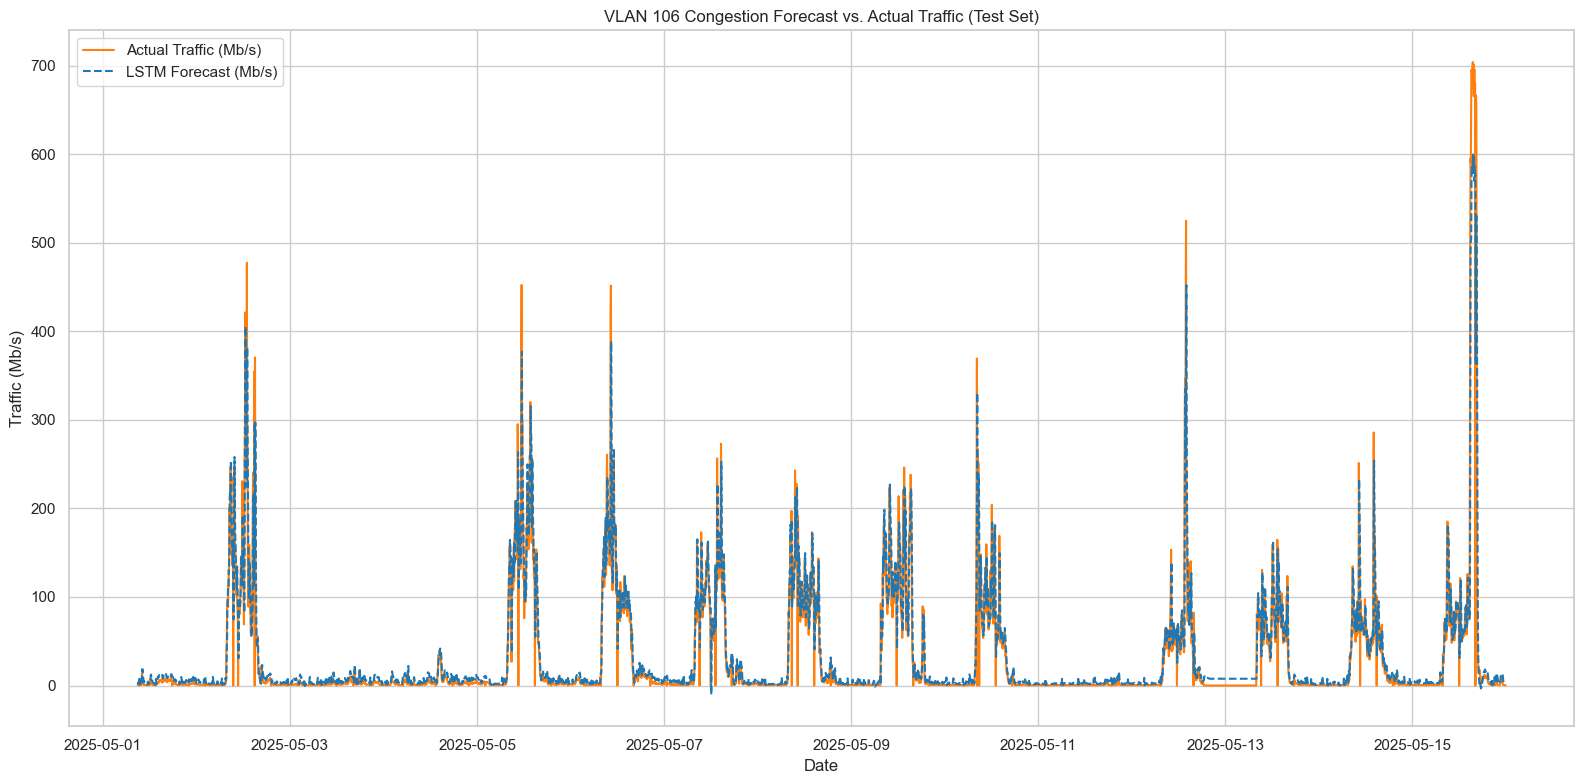


--- PREDICTIVE MODELING COMPLETE ---
You now have a working LSTM model and a visualization of its forecasting performance.


In [26]:
# Predict the traffic on the test set
predictions = model.predict(X_test)

# Inverse transform the predictions to the original Mb/s scale
# The scaler was fitted on all features. We need a dummy array to inverse transform only the target column.
# The target (Total_Mb) is the LAST column in our feature list (index: 4).
dummy_array = np.zeros(shape=(len(predictions), len(features) + 1))
dummy_array[:, -1] = predictions[:, 0]
predictions_unscaled = scaler.inverse_transform(dummy_array)[:, -1]

# Inverse transform the actual test values for comparison
dummy_array = np.zeros(shape=(len(Y_test), len(features) + 1))
dummy_array[:, -1] = Y_test
Y_test_unscaled = scaler.inverse_transform(dummy_array)[:, -1]

# Create a time index for the test set plot
test_index = df_model.index[train_size + LOOKBACK:]

plt.figure(figsize=(16, 8))
plt.plot(test_index, Y_test_unscaled, label='Actual Traffic (Mb/s)', color='#ff7f0e')
plt.plot(test_index, predictions_unscaled, label='LSTM Forecast (Mb/s)', color='#1f77b4', linestyle='--')
plt.title('VLAN 106 Congestion Forecast vs. Actual Traffic (Test Set)')
plt.ylabel('Traffic (Mb/s)')
plt.xlabel('Date')
plt.legend()
plt.tight_layout()
plt.show()

print("\n--- PREDICTIVE MODELING COMPLETE ---")
print("You now have a working LSTM model and a visualization of its forecasting performance.")


# # --- 11.6 ACCURACY AND CLASSIFICATION METRICS ---

In [27]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
# --- REGRESSION METRICS ---
print("\n--- 11.6 REGRESSION ACCURACY METRICS ---")

mae = mean_absolute_error(Y_test_unscaled, predictions_unscaled)
mse = mean_squared_error(Y_test_unscaled, predictions_unscaled)
rmse = np.sqrt(mse)

print(f"Mean Absolute Error (MAE): {mae:.2f} Mb/s")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f} Mb/s")

# --- CLASSIFICATION METRICS (Congestion vs. Normal) ---
print("\n--- 11.6 CLASSIFICATION ACCURACY (Congestion Prediction) ---")

# 1. Define Congestion Threshold: Use the 90th percentile of actual traffic as the threshold
# This defines what "Congestion" means based on the historical data.
CONGESTION_THRESHOLD = np.percentile(Y_test_unscaled, 90)
print(f"Congestion Threshold (90th Percentile): {CONGESTION_THRESHOLD:.2f} Mb/s")

# 2. Convert continuous values to binary (0=Normal, 1=Congestion)
y_true_binary = (Y_test_unscaled >= CONGESTION_THRESHOLD).astype(int)
y_pred_binary = (predictions_unscaled >= CONGESTION_THRESHOLD).astype(int)

# 3. Calculate Classification Metrics
conf_matrix = confusion_matrix(y_true_binary, y_pred_binary)
accuracy = accuracy_score(y_true_binary, y_pred_binary)
precision = precision_score(y_true_binary, y_pred_binary)
recall = recall_score(y_true_binary, y_pred_binary)
f1 = f1_score(y_true_binary, y_pred_binary)

print("\nConfusion Matrix:")
# Print the matrix with labels for clarity
print(f"| True Negative (TN) | False Positive (FP) |")
print(f"| False Negative (FN)| True Positive (TP)  |")
print(conf_matrix)

print(f"\nClassification Metrics:")
print(f"Overall Accuracy: {accuracy:.4f}")
print(f"Precision (Avoiding False Alarms): {precision:.4f}")
print(f"Recall (Catching all Congestion): {recall:.4f}")
print(f"F1-Score (Balance): {f1:.4f}")

print("\nMetrics Calculation Complete.")


--- 11.6 REGRESSION ACCURACY METRICS ---
Mean Absolute Error (MAE): 10.79 Mb/s
Root Mean Squared Error (RMSE): 27.17 Mb/s

--- 11.6 CLASSIFICATION ACCURACY (Congestion Prediction) ---
Congestion Threshold (90th Percentile): 106.31 Mb/s

Confusion Matrix:
| True Negative (TN) | False Positive (FP) |
| False Negative (FN)| True Positive (TP)  |
[[3677  114]
 [  66  356]]

Classification Metrics:
Overall Accuracy: 0.9573
Precision (Avoiding False Alarms): 0.7574
Recall (Catching all Congestion): 0.8436
F1-Score (Balance): 0.7982

Metrics Calculation Complete.


# MODEL DEPLOYMENT ON MOCK DATA

In [1]:
import pandas as pd
import numpy as np
import joblib
from tensorflow.keras.models import load_model

# --- CONFIGURATION ---
MODEL_PATH = 'lstm_congestion_predictor.keras' # The new .keras format file
SCALER_PATH = 'scaler.pkl'
LOOKBACK = 48 # Must match the lookback used during training (48 samples = 4 hours)
# These features must match the order used during training (Section 11)
FEATURES = [
    'VLAN106_Input_B', 'VLAN106_Output_B', 
    'VLAN106_Input_P', 'VLAN106_Output_P',
    'VLAN106_Pkt_Ratio',
    'VLAN106_Total_Mb' # The target metric MUST be the last feature for scaling/inverse_transform
]

# --- 1. HELPER FUNCTION  ---
def create_sequences(data, lookback=48):
    """Converts a 2D dataset into the 3D sequence format required by LSTM."""
    X, Y = [], []
    # Note: We loop from the beginning up to the point where a full sequence can be created
    for i in range(len(data) - lookback + 1):
        # Lookback sequence is the input (X)
        X.append(data[i:(i + lookback), :])
        # Y is included for function signature consistency, though only X is needed for new data prediction
        # The line below is not executed when using the function for deployment's single sequence
        Y.append(0) 
    
    # For deployment, this array will only contain one sequence (if enough data is provided)
    return np.array(X)


# --- 2. LOAD MODEL AND SCALER ---
try:
    # Load the trained model and scaler object
    loaded_model = load_model(MODEL_PATH)
    scaler = joblib.load(SCALER_PATH)
    print(f"✅ Model loaded successfully from: {MODEL_PATH}")
    print(f"✅ Scaler loaded successfully from: {SCALER_PATH}")
except Exception as e:
    print(f"❌ ERROR loading essential files. Ensure '{MODEL_PATH}' and '{SCALER_PATH}' are in the same directory.")
    print(f"Details: {e}")
    exit()


# --- 3. GENERATE MOCK NEW DATA FEED (4 hours of samples) ---

# We generate exactly the LOOKBACK number of data points (48) to form ONE single prediction sequence.
NUM_NEW_POINTS = LOOKBACK 

mock_data = {
    'VLAN106_Input_B': np.random.randint(1000000, 10000000, NUM_NEW_POINTS),
    'VLAN106_Output_B': np.random.randint(500000, 5000000, NUM_NEW_POINTS),
    'VLAN106_Input_P': np.random.randint(1000, 5000, NUM_NEW_POINTS),
    'VLAN106_Output_P': np.random.randint(500, 2000, NUM_NEW_POINTS),
    'VLAN106_Pkt_Ratio': np.random.rand(NUM_NEW_POINTS) * 0.0005 + 0.0003,
    'VLAN106_Total_Mb': np.random.randint(50, 500, NUM_NEW_POINTS) # Target data (last column)
}
new_data_feed = pd.DataFrame(mock_data)


# --- 4. PREPARE DATA FOR PREDICTION ---

# 4a. Scale the new data using the original fitted scaler (CRITICAL STEP)
scaled_new_data = scaler.transform(new_data_feed[FEATURES])

# 4b. Create the sequence. This should result in exactly one sequence of shape (1, 48, 6).
X_new = create_sequences(scaled_new_data, LOOKBACK)

if X_new.shape[0] == 0:
    # This block now uses exit() correctly if not enough data is available.
    print(f"❌ ERROR: Not enough new data points. Need at least {LOOKBACK} timesteps to form one sequence.")
    exit()

# --- 5. GENERATE FORECAST AND INVERSE TRANSFORM ---

# The prediction is made using the ONLY sequence available (X_new[0]).
# We reshape it to ensure it has the required shape (1, 48, 6).
scaled_forecast = loaded_model.predict(X_new[0].reshape(1, LOOKBACK, len(FEATURES)), verbose=0)

# Inverse transform the prediction back to the original Mb/s scale (CRITICAL STEP)
# We need a dummy array with the target prediction placed in the correct column position (-1)
dummy_array = np.zeros(shape=(1, len(FEATURES)))
dummy_array[0, -1] = scaled_forecast[0, 0] 

# Inverse transform the dummy array, and extract the target column's unscaled value
forecast_mbps = scaler.inverse_transform(dummy_array)[0, -1]


# --- 6. OUTPUT ---
print("\n--- CONGESTION FORECAST RESULT ---")
print(f"Using {LOOKBACK} historical samples...")
print(f"Predicted Congestion (t+1): {forecast_mbps:,.2f} Mb/s")
print("----------------------------------")
print("This output predicts the total traffic for the next 5-minute interval.")

✅ Model loaded successfully from: lstm_congestion_predictor.keras
✅ Scaler loaded successfully from: scaler.pkl

--- CONGESTION FORECAST RESULT ---
Using 48 historical samples...
Predicted Congestion (t+1): 53.52 Mb/s
----------------------------------
This output predicts the total traffic for the next 5-minute interval.
